In [65]:
!pip install evaluate


In [ ]:
%pip install transformer_lens
%pip install torchtyping

In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from datasets import load_dataset
import evaluate
import pandas as pd
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class InferenceModel:
    def __init__(self, model_name, device):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", offload_buffers=True)
        self.acc_metric = evaluate.load("accuracy")  
        self.precision_metric = evaluate.load("precision")  
        self.recall_metric = evaluate.load("recall") 
        
        self.df = pd.DataFrame(columns=['pred_answer', 'pred_answertext'])
        self.predictions = []
        self.references = []
        self.answers = []
        self.eval_results = []
        self.model.eval()
        self.logits = []
    def init_eval(self):
        self.acc_metric = evaluate.load("accuracy")  
        self.precision_metric = evaluate.load("precision")  
        self.recall_metric = evaluate.load("recall") 
        self.df = pd.DataFrame(columns=['pred_answer', 'pred_answertext'])
        self.predictions = []
        self.references = []
        self.answers = []
        self.eval_results = []
        
    def get_logprobs(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        outputs = self.model(**inputs, output_hidden_states=True)
        logits = outputs.logits
        # Shape remains, but values are now normalized as log probabilities over the vocabulary.
        logprobs = torch.gather(F.log_softmax(logits, dim=2), 2, output_ids.unsqueeze(2))
        return logprobs, outputs
        
    def inference(self, prompt, max_new_tokens=1):
        """
        Performs inference on a given prompt.
        Returns the decodede output
        """
        generated_text = ''
        if self.model_name == 'Qwen/Qwen2.5-0.5B-Instruct':
            messages = [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
            {"role": "user", "content": prompt}
            ]
            text = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            model_inputs = self.tokenizer([text], return_tensors="pt").to(self.model.device)
            generated_ids = self.model.generate(
                    **model_inputs,
                    do_sample=False,
                    temperature=None,
                    top_p=None,
                    top_k=None,
                    max_new_tokens=max_new_tokens
                )
            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
            ]
            
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        else:
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
            output = self.model.generate(
                **inputs, 
                do_sample=False,
                temperature=None,
                top_p=None,
                top_k=None,
                max_new_tokens=1)
            # print(f"output: {output}")
            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output)
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        self.answers.append(generated_text)
        # answer = "1" if "option1" in generated_text else "2" if "option2" in generated_text else None
        
        return generated_text

    def batch_inference(self, prompts):
        """
        Perform batch inference.
        """
        inputs = self.tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(self.model.device)
        outputs = self.model.generate(**inputs, max_new_tokens=50)
        generated_texts = []
        for input_ids, output_ids in zip(inputs.input_ids, outputs):
            generated_ids = [
                output_ids[len(input_ids):]
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            generated_texts.append(generated_text)
        self.answers.extend(generated_texts)
        return generated_texts

    def eval(self):
        """
        Evaluates the predictions against the references 
        """
        accuracy_results = self.acc_metric.compute(predictions=self.predictions, references=self.references)

        precision_results = self.precision_metric.compute(predictions=self.predictions, references=self.references, average="macro")

        recall_results = self.recall_metric.compute(predictions=self.predictions, references=self.references, average="macro")

        results = {
            'acc' : accuracy_results,
            'prec' : precision_results,
            'recall' : recall_results
        }
        self.eval_results.append(results)
        print("Evaluation Results:\n", results)
        return results

    
    def parse_save_output(self, generated_text, unique_labels, current_labeltexts, currentlabel):
        """
        generated_text: output from model.generate (e.g. '1', 'option 1', 'anna')
        unique_labels: unique labels from dataset (list of string e.g. ["1", "2"])
        current_labeltexts: the current label options (dict of current label text e.g. {1:'anna', 2:'susan'})
        currentlabel = the current reference label from dataset (string, the dataset['answer']. e.g. "2", "1" )
        """
        pred = None
        clean_generated_text = generated_text.lower().strip()
        for i in unique_labels:
            if str(i) in clean_generated_text or current_labeltexts[int(i)].lower().strip() in clean_generated_text or current_labeltexts[int(i)].lower().removeprefix("the").strip() in clean_generated_text :
                pred = i
                break
        # print(f"gt: {generated_text}")
        # print(f"pred : {pred}")
        if pred == None:
            pred = "9"
        self.predictions.append(pred)
        self.references.append(currentlabel)
        ans_dict = ({'pred_answer':pred, 'pred_answertext' : generated_text})
        # print(f"ans_dict {ans_dict}")
        self.df.loc[len(self.df)] = ans_dict
        return pred



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:

massive_qwen = InferenceModel("Qwen/Qwen2.5-0.5B-Instruct", device)
# xwinograd_bloomz = InferenceModel("bigscience/bloomz-560m", device)
# xnli_qwen = InferenceModel("Qwen/Qwen2.5-0.5B-Instruct", device)
# xnli_bloomz = InferenceModel("bigscience/bloomz-560m", device)


In [66]:
massive_qwen.model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

The neurons we're interested is in act_fn in Qwen2MLP

In [ ]:
# import torch 
# from datasets import get_dataset_config_names
# from tqdm import tqdm

# def inference_xwinograd(model_name, infer_model):
#     eval_result = {}
#     dataset_name = "AmazonScience/massive"
#     configs = get_dataset_config_names(dataset_name)
#     for lang in configs if not lang.startswith("all") :
#         ds = load_dataset(dataset_name, lang, split="test")
#         for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
#             # print(data)
#             current_labeltexts = {1:data['option1'], 2:data['option2']}
#             prompt = (
#                     f"{data['sentence']}\n"
#                     # f"Does _ refer to {current_labeltexts[2]}? True or False?"
#                     f"Who does '_' refer to? The answer should be one of '1: {current_labeltexts[1]}' or '2: {current_labeltexts[2]}'.\n"
#                     f"Answer:"
            
#                 )
#             # print(prompt)
#             generated_text = infer_model.inference(prompt)
#             # print(f"gen_text {generated_text}")
#             answer = generated_text.split()[0]
#             print(generated_text)
            
#             pred = infer_model.parse_save_output(
#                 generated_text, 
#                 ds['answer'], 
#                 current_labeltexts, 
#                 data['answer'])
#             break # one sample
        
#         evaluated = infer_model.eval()
#         eval_result[lang] = evaluated
#         print(f"Done with lang: {lang}")
#         break # one language
#     infer_model.df.to_csv(f"out_{model_name.split('/')[-1]}_{dataset_name.split('/')[-1]}", index=False)
#     return eval_result


In [13]:
infer_model = massive_qwen
for i in range(len(infer_model.model.model.layers)):
    mlp = infer_model.model.model.layers[i].mlp
    mlp.act_fn._forward_hooks.clear()
    mlp.gate_proj._forward_hooks.clear()
    mlp.up_proj._forward_hooks.clear()


### cek apakah output act_fn == output Act_function(first linear transformation)

alternatif lain bisa pake:
- transformerlens
- override method forward langsung di model (ini lebih cepat katanya)

In [9]:
layer_outputs = {}

def get_activation(name): # biar ada namanya
    def hook_fn(module, input, output):
        # `output` is the result after the activation function
        print(f"Layer: {name}, output Shape: {output.shape}")
        print("Output", output)
        layer_outputs[name] = output
    return hook_fn


#### 1. pake hook langsung di act_fn

In [131]:
infer_model = massive_qwen

eval_result = {}
dataset_name = "AmazonScience/massive"
configs = get_dataset_config_names(dataset_name)
for lang in [lang for lang in configs if not lang.startswith("all")]:
    ds = load_dataset(dataset_name, lang, split="test")
    for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
        
        # Assuming `model` is your Qwen2ForCausalLM instance
        layer_index = 1  # or any layer you are interested in
        mlp = infer_model.model.model.layers[layer_index].mlp
        mlp.act_fn._forward_hooks.clear()
        # Register the hook on the activation function
        handle = mlp.act_fn.register_forward_hook(get_activation("mlp1_act_fn"))
        print(f"data: {data['utt']}")
        # Forward pass through the model
        prompt = (
                f"{data['utt']}"
            )
        # print(prompt)
        generated_text = infer_model.inference(prompt)
        # Remove the hook when done
        handle.remove()
        
        # print(f"gen_text {generated_text}")
       
        break # one sample
    
    print(f"Done with lang: {lang}")
    break # 

data: maak my wakker om vyf v. m. die week
Layer: mlp1_act_fn, output Shape: torch.Size([1, 15, 4864])
Output tensor([[[-0.2200, -0.2780, -0.0797,  ...,  0.2259, -0.0492, -0.2783],
         [-0.2672, -0.2161, -0.0416,  ...,  0.1205, -0.1830,  0.0184],
         [ 0.3361, -0.2575, -0.0783,  ..., -0.2051, -0.2675, -0.2664],
         ...,
         [ 0.2957, -0.2782, -0.0507,  ...,  0.0811, -0.0333, -0.2753],
         [ 0.0134, -0.2242,  0.1403,  ..., -0.2170, -0.2511, -0.2737],
         [ 0.2627, -0.1525, -0.1808,  ..., -0.2394, -0.0415, -0.2748]]],
       device='cuda:0')
Done with lang: af-ZA


#### 2. hitung sendiri act_fn di output linear transformation pertama 

In [133]:
infer_model = massive_qwen
eval_result = {}
dataset_name = "AmazonScience/massive"
configs = get_dataset_config_names(dataset_name)
for lang in [lang for lang in configs if not lang.startswith("all")]:
    ds = load_dataset(dataset_name, lang, split="test")
    for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
        
        layer_index = 1  # or any layer you are interested in
        mlp = infer_model.model.model.layers[layer_index].mlp
        mlp.act_fn._forward_hooks.clear()
        # Register the hook on the activation function
        handle = mlp.gate_proj.register_forward_hook(get_activation("mlp1_gate_proj"))
        handle2 = mlp.up_proj.register_forward_hook(get_activation("mlp1_up_proj"))

        # register all callback hook functions
        handlers = [handle, handle2]
        print(f"data: {data['utt']}")
        # Forward pass through the model
        prompt = (
                f"{data['utt']}"
            )
        # print(prompt)

        # inputs = infer_model.tokenizer(prompt, return_tensors="pt").to(infer_model.model.device)
        
        # Generate output
        # output = self.model.generate(
        #     **inputs, 
        #     do_sample=False,
        #     temperature=None,
        #     top_p=None,
        #     top_k=None,
        #     max_new_tokens=1
        # )

        # output = infer_model.model.generate(**inputs, max_new_tokens=1)  # Force no caching
        generated_text = infer_model.inference(prompt)
        
        # outputs = infer_model.model(**inputs)
        # logits = outputs.logits  # Shape: [batch_size, seq_len, vocab_size]
        
        # # Get the last token's logits (the next predicted token)
        # next_token = logits[:, -1, :].argmax(dim=-1)  # Take the most probable token
        # Remove the hook when done
        for i in handlers:
            i.remove()
        
        # print(f"gen_text {generated_text}")
       
        break # one sample
    
    print(f"Done with lang: {lang}")
    break # 

data: maak my wakker om vyf v. m. die week
Layer: mlp1_gate_proj, output Shape: torch.Size([1, 15, 4864])
Output tensor([[[-0.6352, -1.2145, -0.1746,  ...,  0.3804, -0.1038, -1.3209],
         [-0.9765, -0.6163, -0.0870,  ...,  0.2175, -0.4781,  0.0362],
         [ 0.5332, -0.8758, -0.1713,  ..., -0.5665, -0.9804, -0.9670],
         ...,
         [ 0.4789, -1.2289, -0.1071,  ...,  0.1508, -0.0691, -1.1138],
         [ 0.0264, -0.6563,  0.2496,  ..., -0.6205, -1.8534, -1.4989],
         [ 0.4331, -0.3743, -0.4702,  ..., -0.7424, -0.0868, -1.4712]]],
       device='cuda:0')
Layer: mlp1_up_proj, output Shape: torch.Size([1, 15, 4864])
Output tensor([[[-0.7753, -0.5051,  0.1669,  ...,  0.8807,  0.2014, -0.2443],
         [ 0.0411, -0.3244,  0.0091,  ...,  0.2595,  0.6894,  0.7306],
         [ 0.3624,  0.0466, -0.4368,  ...,  0.1667,  0.0335, -0.3440],
         ...,
         [ 0.6712, -0.4245,  0.0857,  ...,  0.3670,  0.3262,  0.3288],
         [-0.1185,  0.1655,  0.2573,  ...,  0.4110,  0.

In [105]:
infer_model.tokenizer.bos_token_id # gaada

In [136]:
layer_outputs['mlp1_gate_proj'].shape

torch.Size([1, 15, 4864])

In [49]:
torch.nn.SiLU()

SiLU()

In [56]:
activation = nn.SiLU()  # Create an instance
activation(layer_outputs['mlp1_gate_proj'])  # Apply it to the tensor


tensor([[[-0.0968, -0.2006,  0.3872,  ...,  0.0117, -0.2499, -0.2647],
         [-0.1168, -0.2624,  0.3224,  ...,  0.1731,  0.1985, -0.2622],
         [-0.2417, -0.2147,  0.2050,  ...,  0.2737, -0.1611, -0.0294],
         ...,
         [-0.1356, -0.2709, -0.0119,  ..., -0.0455, -0.1010, -0.2117],
         [ 0.0991, -0.0921,  0.2615,  ..., -0.2462, -0.0471, -0.0277],
         [ 0.1501, -0.2488,  0.1197,  ...,  0.1976, -0.1996, -0.1625]]],
       device='cuda:0')

In [139]:
import torch.nn.functional as F

manual_silu_output = F.silu(layer_outputs['mlp1_gate_proj'])  # Correct way
manual_silu_output

tensor([[[-0.2200, -0.2780, -0.0797,  ...,  0.2259, -0.0492, -0.2783],
         [-0.2672, -0.2161, -0.0416,  ...,  0.1205, -0.1830,  0.0184],
         [ 0.3361, -0.2575, -0.0783,  ..., -0.2051, -0.2675, -0.2664],
         ...,
         [ 0.2957, -0.2782, -0.0507,  ...,  0.0811, -0.0333, -0.2753],
         [ 0.0134, -0.2242,  0.1403,  ..., -0.2170, -0.2511, -0.2737],
         [ 0.2627, -0.1525, -0.1808,  ..., -0.2394, -0.0415, -0.2748]]],
       device='cuda:0')

In [138]:
torch.allclose(layer_outputs['mlp1_act_fn'], manual_silu_output, atol=1e-5)


True

SAMA!!!

#### 3. pake transformerlens

beda, mungkin karena beda cara generatenya, atau karena ada prepend_bos nya

In [66]:
# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

In [67]:
# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "Qwen/Qwen2.5-0.5B", device=device
)

# Get the default device used
device: torch.device = utils.get_device()

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Loaded pretrained model Qwen/Qwen2.5-0.5B into HookedTransformer


In [70]:
example_prompt = ["maak my wakker om vyf v. m. die week."]
example_answer = " "
utils.test_prompt(example_prompt[0], example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'ma', 'ak', ' my', ' w', 'ak', 'ker', ' om', ' vy', 'f', ' v', '.', ' m', '.', ' die', ' week', '.']
Tokenized answer: [' ']


Performance on answer token:
Rank: 0        Logit: 13.77 Prob:  2.60% Token: | |

Top 0th token. Logit: 13.77 Prob:  2.60% Token: | |
Top 1th token. Logit: 13.71 Prob:  2.45% Token: |<|endoftext|>|
Top 2th token. Logit: 13.55 Prob:  2.07% Token: | 
|
Top 3th token. Logit: 13.46 Prob:  1.90% Token: | (|
Top 4th token. Logit: 13.35 Prob:  1.71% Token: | V|
Top 5th token. Logit: 13.29 Prob:  1.61% Token: | 

|
Top 6th token. Logit: 13.24 Prob:  1.53% Token: | Ik|
Top 7th token. Logit: 13.21 Prob:  1.48% Token: | -|
Top 8th token. Logit: 13.13 Prob:  1.37% Token: | I|
Top 9th token. Logit: 13.06 Prob:  1.27% Token: | De|


Ranks of the answer tokens: [(' ', 0)]

In [73]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-23): 24 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

In [10]:
from torchtyping import TensorType as TT


In [72]:
tokens = model.to_tokens(example_prompt, prepend_bos=True)
tokens

tensor([[151643,   1728,    585,    847,    289,    585,   7052,   7861,  45259,
             69,    348,     13,    296,     13,   2746,   2003,     13]],
       device='cuda:0')

In [92]:
def patch_resid(out: TT["batch", "pos", "d_model"], hook=None):
    # corrupted_resid[:, pos, :] = clean_cache[hook.name][:, pos, :]
    print(out)
    return out

In [98]:
patched_logits = model.run_with_hooks(
    tokens,
    fwd_hooks=[
        ("blocks.1.hook_mlp_out", patch_resid)
    ],
    return_type="none"
)


tensor([[[ 1.0535e-01,  2.1015e-01,  1.9084e-01,  ...,  1.7543e-01,
          -2.0344e-01,  4.4151e-01],
         [-9.0139e-02, -1.1863e-02,  1.7293e-01,  ..., -2.0146e-01,
          -1.0280e-01,  1.1439e-01],
         [ 1.6705e-01, -5.7129e-02, -5.6982e-02,  ...,  5.1725e-02,
           5.6933e-03,  1.8816e-01],
         ...,
         [-6.0515e-02, -2.3085e-01, -1.8566e-01,  ..., -3.2851e-02,
          -6.0347e-02,  1.2400e-01],
         [-2.4668e-01, -1.6782e-04,  1.0682e-01,  ...,  1.0031e-01,
          -1.2606e-02,  1.6048e-01],
         [ 1.1506e-02, -4.2615e-02,  3.9433e-02,  ...,  4.2605e-02,
          -7.2782e-03,  2.6309e-02]]], device='cuda:0',
       grad_fn=<ViewBackward0>)


### masukin hasil inference ke tabel

In [ ]:
infer_model = massive_qwen



- ada 2 dict untuk setiap language: 
-> *raw_values_avg_tokens* dan *raw_values_last_token*:

key-nya nama layer dari layer pertama sampe terakhir. setiap valuenya
ukurannya (num_row_in_dataset, hidden_dim) ini neuronnya bisa averaged tokens atau last token. output keluaran suatu neuron adlaah (batch_size, seq_len, num_neurons_di_suatu_layer) tapi seq_len menjadi 1 karena diambil averagenya (raw_values_avg_tokens) atau last token (raw_values_last_token) dari seq) sehingga (num_row_in_dataset, 1, hidden_dim) dijadiin (num_row_in_dataset, hidden_dim) aja.


- tensor *full_raw_values_avg_tokens* dan *full_raw_values_last_token*: adalah tensor dari raw_values_avg_tokens atau raw_values_last_token yang nyatuin semua neurons dari semua layer. ukurannya (batch_size, num_neurons_total_seluruh_layer)


- tensor *full_raw_values*: adalah tensor yang nyatuin full_raw_values_avg_tokens dan full_raw_values_last_token. ukurannya (2, batch_size, num_neurons_total_seluruh_layer). yg pertama full_raw_values_avg_tokens kedua full_raw_values_last_token.


### start playground

In [61]:
# IMP: ini buat nyatuin tiap entry di dataset
import torch

tensor1 = torch.randn(1, 2, 3)  # Shape: (1, 2, 3)
print(tensor1)
tensor2 = torch.randn(2, 2, 3)  # Shape: (2, 2, 3)
print(tensor2)
# Concatenate along dim=0
result = torch.cat([tensor1, tensor2], dim=0)

print(result.shape)  # Output: (3, 2, 3)


tensor([[[-0.3380, -0.4270, -0.4377],
         [ 1.3522, -1.5015, -0.1378]]])
tensor([[[ 1.0448,  1.8319,  0.7205],
         [-0.1121, -0.0309, -0.1503]],

        [[ 1.8928,  1.3067, -0.0662],
         [-0.4235, -2.3768,  0.0641]]])
torch.Size([3, 2, 3])


In [62]:
tensor2 = torch.tensor([[1, 2], [3, 4]])  # Shape: [1, 2]
# print(tensor2.float().mean(dim=1))
print(tensor2.float()[-1, :])

tensor([3., 4.])


In [99]:
tensor2 = torch.tensor([[1, 2], [3, 4]])  # Shape: [1, 2]
print(tensor2.shape)
lists = [tensor2, tensor2, tensor2]
stacked = torch.stack(lists, dim=0)
print(stacked.shape)

torch.Size([2, 2])
torch.Size([3, 2, 2])


In [64]:
raw_values_avg_tokens = {}
raw_values_last_token = {}
# ini yg raw value


# def aggregate_across_tokens(output, is_averaged_tokens):
#     if is_averaged_tokens:
#         output = output.float().mean(dim=1, keepdim=True) 
#     else:
#         output = output.float()[:, -1:] # get the last token
#     return output

def save_raw_vals_to_dict(name, dictname, savees):
    if not name in dictname:
        dictname[name] = savees
    else:
        dictname[name] = torch.cat([dictname[name], savees], dim=0)

def coba(name, is_averaged_tokens, output):
    # output is always (batch size, 1, hidden dim)
    # print(f"Layer: {name}, output Shape: {output.shape}")
    # print("Output", output)
    # output is always (batch size, hidden dim), where hidden dim is the number of neurons in a layer.
    output 
    if is_averaged_tokens: # simpen average value across tokens
        output = output.float().mean(dim=1) 
        save_raw_vals_to_dict(name, raw_values_avg_tokens, output)
    else:
        output = output.float()[-1,:] # simpen the last token
        save_raw_vals_to_dict(name, raw_values_last_token, output)
        
    

In [65]:
x = torch.tensor([[[1, 2], [3, 4]]])
y = torch.tensor([[[5, 6], [7, 8]]])
z = torch.tensor([[[1, 6], [3, 2]]])

# layer_outputs['a'] = x
coba("a", True, x)
coba("a", True, y)
print(raw_values_avg_tokens['a'])
print(raw_values_avg_tokens['a'].shape)

coba("a", False, y)
coba("a", False, z)
print(raw_values_last_token['a'])
print(raw_values_last_token['a'].shape)


tensor([[2., 3.],
        [6., 7.]])
torch.Size([2, 2])
tensor([[5., 6.],
        [7., 8.],
        [1., 6.],
        [3., 2.]])
torch.Size([4, 2])


In [17]:
x = torch.tensor([[[1, 2], [3, 4]]])
# layer_outputs['a'] = x
coba("b", True, y)
coba("b", True, y)
print(raw_values_avg_tokens['b'])
print(raw_values_avg_tokens['b'].shape)

coba("b", False, x)
coba("b", False, x)

print(raw_values_last_token['b'])
print(raw_values_last_token['b'].shape)


tensor([[6., 7.],
        [6., 7.]])
torch.Size([2, 2])
tensor([[3., 4.],
        [3., 4.]])
torch.Size([2, 2])


In [29]:
list(raw_values_avg_tokens.values())

[tensor([[2., 3.],
         [6., 7.]]),
 tensor([[6., 7.],
         [6., 7.]])]

In [33]:
# IMP: nyatuin tiap layer OKE
full_raw_values_avg_tokens = list(raw_values_avg_tokens.values())[0]
full_raw_values_last_token = list(raw_values_last_token.values())[0]

# print(full_raw_values_avg_tokens.shape)
# print(full_raw_values_last_token.shape)
for i in list(raw_values_avg_tokens.values())[1:]:
    # print(i.shape)
    full_raw_values_avg_tokens = torch.cat([full_raw_values_avg_tokens, i], dim=-1)
for i in list(raw_values_last_token.values())[1:]:
    full_raw_values_last_token = torch.cat([full_raw_values_last_token, i], dim=-1)

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])


In [34]:
print(full_raw_values_avg_tokens)
print(full_raw_values_last_token)


tensor([[2., 3., 6., 7.],
        [6., 7., 6., 7.]])
tensor([[7., 8., 3., 4.],
        [3., 2., 3., 4.]])


In [39]:
full_raw_values_last_token.shape

torch.Size([2, 4])

In [36]:
# IMP: nyatuin avg dan last
full_raw_values = torch.stack((full_raw_values_avg_tokens, full_raw_values_last_token), dim=0)
# stack buat nyatuin avg token dan last token OKE
# torch.stack((raw_values_last_token['a'], raw_values_avg_tokens['a']), dim=0)
full_raw_values

tensor([[[2., 3., 6., 7.],
         [6., 7., 6., 7.]],

        [[7., 8., 3., 4.],
         [3., 2., 3., 4.]]])

In [37]:
full_raw_values.shape

torch.Size([2, 2, 4])

In [ ]:
ex = torch.tensor(
    [[[[0, 1, 2, 3],
        [4, 5, 6, 7]]]]
)
ex.transpose(-1,-2)

### === end playground

In [4]:
raw_values_avg_tokens = {}
raw_values_last_token = {}
full_raw_values_avg_tokens = []
full_raw_values_last_token = []
full_raw_values = []


In [5]:
def save_raw_vals_to_dict(name, dictname, savees):
    if not name in dictname:
        dictname[name] = savees
    else:
        dictname[name] = torch.cat([dictname[name], savees], dim=0)
    


In [27]:
def clean_hooks():
    for i in range(len(infer_model.model.model.layers)):
        mlp = infer_model.model.model.layers[i].mlp
        mlp.act_fn._forward_hooks.clear()

In [7]:
clean_hooks()

NameError: name 'infer_model' is not defined

In [8]:
def get_activation_mlp(name): 
    """
        name (str): buat namain layer
        is_averaged_tokens (boolean): true if avergaed across tokens, else get the last token
    """
    def hook_fn(module, input, output):
        global raw_values_avg_tokens
        global raw_values_last_token
        # print(f"Layer: {name}, output Shape: {output.shape}")
        # print("Output", output)
        # output is always (batch size, dim_neuron_in_a_layer)
        # if is_averaged_tokens: # simpen average value across tokens
        avg_output = output.detach().half().mean(dim=1).cpu() 
        save_raw_vals_to_dict(name, raw_values_avg_tokens, avg_output)
        # else:
        last_output = output.float()[:, -1,:].cpu() # simpen the last token
        save_raw_vals_to_dict(name, raw_values_last_token, last_output)
        # print(f"ini raw_values_avg_token {raw_values_avg_tokens}")
        # print(len(raw_values_last_token.values()))
        
            
        
    return hook_fn


In [24]:
def concat_neuron_layers(raw_values_avg_tokens, raw_values_last_token):
    full_raw_values_avg_tokens = list(raw_values_avg_tokens.values())[0]
    full_raw_values_last_token = list(raw_values_last_token.values())[0]
    
    # print(full_raw_values_avg_tokens.shape)
    # print(full_raw_values_last_token.shape)
    for i in list(raw_values_avg_tokens.values())[1:]:
        # print(i.shape)
        full_raw_values_avg_tokens = torch.cat([full_raw_values_avg_tokens, i], dim=-1).cpu()
    for i in list(raw_values_last_token.values())[1:]:
        full_raw_values_last_token = torch.cat([full_raw_values_last_token, i], dim=-1).cpu()
    # print(f"shape full_raw_values_last_token {full_raw_values_last_token.shape}")
    return full_raw_values_avg_tokens, full_raw_values_last_token

In [25]:
def merge_avg_last(full_raw_values_avg_tokens, full_raw_values_last_token):
    # print(f"shape full_raw_values_last_token {full_raw_values_last_token.shape}")
    full_raw_values = torch.stack((full_raw_values_avg_tokens, full_raw_values_last_token), dim=0).cpu()
    return full_raw_values
    

In [26]:
def register_hook(infer_model, handlers): #gadipake
    # remove_hooks(handlers)  # Remove any existing hooks before adding new ones
    clean_hooks()
    num_layers = len(infer_model.model.model.layers)
    handlers = []
    for i in range (num_layers):
        mlp = infer_model.model.model.layers[i].mlp
        handlers.append(mlp.act_fn.register_forward_hook(get_activation_mlp(f"mlp{i}_act_fn")))
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)

    # for handler in handlers:
    #     handler.remove()
        

In [27]:
def remove_hooks(handlers):
    for handler in handlers:
        handler.remove()
    handlers.clear()
    return handlers

In [28]:
clean_hooks()

In [29]:
print(infer_model.model.model.layers[0].mlp.act_fn._forward_hooks)


OrderedDict()


### prompt tanpa predict

In [20]:
import torch 
from datasets import get_dataset_config_names
from tqdm import tqdm


infer_model = massive_qwen

eval_result = {}
all_languages = []
num_layers = len(infer_model.model.model.layers)
handlers = []


# print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)

dataset_name = "AmazonScience/massive"
configs = get_dataset_config_names(dataset_name, trust_remote_code=True)
n_instances = 0
n_lang = 0
language_dict = {}
# register_hook(infer_model, handlers)

for lang in [lang for lang in configs if not lang.startswith("all")]:
    # if n_lang >= 200:
    #     break
    language_dict[n_lang] = lang 
    raw_values_avg_tokens.clear()
    raw_values_last_token.clear()
    full_raw_values_avg_tokens = []
    full_raw_values_last_token = []
    full_raw_values = []
    for i in range(len(infer_model.model.model.layers)):
        mlp = infer_model.model.model.layers[i].mlp
        mlp.act_fn._forward_hooks.clear()
    # print(f"lang: {lang}")
    # handlers = remove_hooks(handlers)
    # clean_hooks()
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)

    # register_hook(infer_model, handlers)
    num_layers = len(infer_model.model.model.layers)
    for i in range (num_layers):
        mlp = infer_model.model.model.layers[i].mlp
        handlers.append(mlp.act_fn.register_forward_hook(get_activation_mlp(f"mlp{i}_act_fn")))
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)
    # clean_hooks()
    # remove_hooks(handlers)
    
    ds = load_dataset(dataset_name, lang, split="test")
    for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
        if n_instances >= 200:
            break
        # Assuming `model` is your Qwen2ForCausalLM instance
        # layer_index = 1  # or any layer you are interested in
        
        # print(f"data: {data['utt']}")
        # Forward pass through the model
        prompt = (
                f"{data['utt']}"
            )
        # print(f"prompt {prompt}")
        generated_text = infer_model.inference(prompt)
        # print(f"data: {prompt}")
        
        # print(f"gen_text {generated_text}")
       
        n_instances += 1
        # print(f"🔵 After inference, raw_values_avg_tokens keys: {list(raw_values_avg_tokens.keys())}")


    # print(f"🔵 After inference language, raw_values_avg_tokens: {list(raw_values_avg_tokens.values())}")
    full_raw_values_avg_tokens, full_raw_values_last_token = concat_neuron_layers(raw_values_avg_tokens, raw_values_last_token)
    full_raw_values = merge_avg_last(full_raw_values_avg_tokens, full_raw_values_last_token)
    all_languages.append(full_raw_values)
    # print(full_raw_values.shape)
    n_lang += 1
    print(f"Done with lang: {lang}")
    for handler in handlers:
        handler.remove()
    # break # 
    n_instances = 0
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)



README.md:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

massive.py:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

af-ZA%2Ftrain%2F0000.parquet:   0%|          | 0.00/785k [00:00<?, ?B/s]

af-ZA%2Fvalidation%2F0000.parquet:   0%|          | 0.00/158k [00:00<?, ?B/s]

af-ZA%2Ftest%2F0000.parquet:   0%|          | 0.00/217k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: af-ZA


am-ET%2Ftrain%2F0000.parquet:   0%|          | 0.00/994k [00:00<?, ?B/s]

am-ET%2Fvalidation%2F0000.parquet:   0%|          | 0.00/196k [00:00<?, ?B/s]

am-ET%2Ftest%2F0000.parquet:   0%|          | 0.00/270k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: am-ET


ar-SA%2Ftrain%2F0000.parquet:   0%|          | 0.00/860k [00:00<?, ?B/s]

ar-SA%2Fvalidation%2F0000.parquet:   0%|          | 0.00/171k [00:00<?, ?B/s]

ar-SA%2Ftest%2F0000.parquet:   0%|          | 0.00/235k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: ar-SA


az-AZ%2Ftrain%2F0000.parquet:   0%|          | 0.00/811k [00:00<?, ?B/s]

az-AZ%2Fvalidation%2F0000.parquet:   0%|          | 0.00/164k [00:00<?, ?B/s]

az-AZ%2Ftest%2F0000.parquet:   0%|          | 0.00/224k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: az-AZ


0000.parquet:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

bn-BD%2Fvalidation%2F0000.parquet:   0%|          | 0.00/210k [00:00<?, ?B/s]

bn-BD%2Ftest%2F0000.parquet:   0%|          | 0.00/291k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: bn-BD


ca-ES%2Ftrain%2F0000.parquet:   0%|          | 0.00/793k [00:00<?, ?B/s]

ca-ES%2Fvalidation%2F0000.parquet:   0%|          | 0.00/160k [00:00<?, ?B/s]

ca-ES%2Ftest%2F0000.parquet:   0%|          | 0.00/219k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: ca-ES


cy-GB%2Ftrain%2F0000.parquet:   0%|          | 0.00/788k [00:00<?, ?B/s]

cy-GB%2Fvalidation%2F0000.parquet:   0%|          | 0.00/160k [00:00<?, ?B/s]

cy-GB%2Ftest%2F0000.parquet:   0%|          | 0.00/218k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: cy-GB


da-DK%2Ftrain%2F0000.parquet:   0%|          | 0.00/756k [00:00<?, ?B/s]

da-DK%2Fvalidation%2F0000.parquet:   0%|          | 0.00/153k [00:00<?, ?B/s]

da-DK%2Ftest%2F0000.parquet:   0%|          | 0.00/210k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: da-DK


de-DE%2Ftrain%2F0000.parquet:   0%|          | 0.00/815k [00:00<?, ?B/s]

de-DE%2Fvalidation%2F0000.parquet:   0%|          | 0.00/163k [00:00<?, ?B/s]

de-DE%2Ftest%2F0000.parquet:   0%|          | 0.00/226k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: de-DE


0000.parquet:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

el-GR%2Fvalidation%2F0000.parquet:   0%|          | 0.00/210k [00:00<?, ?B/s]

el-GR%2Ftest%2F0000.parquet:   0%|          | 0.00/288k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: el-GR


en-US%2Ftrain%2F0000.parquet:   0%|          | 0.00/676k [00:00<?, ?B/s]

en-US%2Fvalidation%2F0000.parquet:   0%|          | 0.00/140k [00:00<?, ?B/s]

en-US%2Ftest%2F0000.parquet:   0%|          | 0.00/191k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: en-US


es-ES%2Ftrain%2F0000.parquet:   0%|          | 0.00/806k [00:00<?, ?B/s]

es-ES%2Fvalidation%2F0000.parquet:   0%|          | 0.00/163k [00:00<?, ?B/s]

es-ES%2Ftest%2F0000.parquet:   0%|          | 0.00/222k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: es-ES


fa-IR%2Ftrain%2F0000.parquet:   0%|          | 0.00/908k [00:00<?, ?B/s]

fa-IR%2Fvalidation%2F0000.parquet:   0%|          | 0.00/180k [00:00<?, ?B/s]

fa-IR%2Ftest%2F0000.parquet:   0%|          | 0.00/249k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: fa-IR


fi-FI%2Ftrain%2F0000.parquet:   0%|          | 0.00/791k [00:00<?, ?B/s]

fi-FI%2Fvalidation%2F0000.parquet:   0%|          | 0.00/159k [00:00<?, ?B/s]

fi-FI%2Ftest%2F0000.parquet:   0%|          | 0.00/219k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

KeyboardInterrupt: 

### prompt dengan predict intent

In [31]:
import torch 
from datasets import get_dataset_config_names
from tqdm import tqdm


infer_model = massive_qwen

eval_result = {}
all_languages = []
num_layers = len(infer_model.model.model.layers)
handlers = []


# print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)

dataset_name = "AmazonScience/massive"
configs = get_dataset_config_names(dataset_name, trust_remote_code=True)
n_instances = 0
n_lang = 0
language_dict = {}
# register_hook(infer_model, handlers)

for lang in [lang for lang in configs if not lang.startswith("all")]:
    if n_lang >= 200:
        break
    language_dict[n_lang] = lang 
    raw_values_avg_tokens.clear()
    raw_values_last_token.clear()
    full_raw_values_avg_tokens = []
    full_raw_values_last_token = []
    full_raw_values = []
    for i in range(len(infer_model.model.model.layers)):
        mlp = infer_model.model.model.layers[i].mlp
        mlp.act_fn._forward_hooks.clear()
    # print(f"lang: {lang}")
    # handlers = remove_hooks(handlers)
    # clean_hooks()
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)

    # register_hook(infer_model, handlers)
    num_layers = len(infer_model.model.model.layers)
    for i in range (num_layers):
        mlp = infer_model.model.model.layers[i].mlp
        handlers.append(mlp.act_fn.register_forward_hook(get_activation_mlp(f"mlp{i}_act_fn")))
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)
    # clean_hooks()
    # remove_hooks(handlers)
    
    ds = load_dataset(dataset_name, lang, split="test")
    intents = ds.features['intent'].names
    
    scenarios = ds.features['scenario'].names
    for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
        if n_instances >= 200:
            break
        label_intent = intents[data['intent']]
        label_intent_no = -1
        scenario = scenarios[data['scenario']]
        
        intent_options = [intent[intent.find('_')+1:] for intent in intents if intent.startswith(scenario)]
        
        current_labeltexts = dict()
        for i, label in enumerate(intent_options):
            if label_intent.endswith(label):
                label_intent_no = i
            current_labeltexts[i] = label
        prompt = (
            f"""
            Instruction: Classify the intent of the following utterance.  
            Utterance: {data['utt']}.  
            Options: {scenario} {', '.join(intent_options)}. 
            Intent:      
            """
            )
        # print(f"prompt {prompt}")
        generated_text = infer_model.inference(prompt)
        # print(f"data: {prompt}")
        
        # print(f"gen_text {generated_text}")
       
        n_instances += 1
        # break
        # print(f"🔵 After inference, raw_values_avg_tokens keys: {list(raw_values_avg_tokens.keys())}")


    # print(f"🔵 After inference language, raw_values_avg_tokens: {list(raw_values_avg_tokens.values())}")
    full_raw_values_avg_tokens, full_raw_values_last_token = concat_neuron_layers(raw_values_avg_tokens, raw_values_last_token)
    full_raw_values = merge_avg_last(full_raw_values_avg_tokens, full_raw_values_last_token)
    all_languages.append(full_raw_values)
    # print(full_raw_values.shape)
    n_lang += 1
    print(f"Done with lang: {lang}")
    for handler in handlers:
        handler.remove()
    # if n_lang >= 2: break # 
    n_instances = 0
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)



Done with lang: af-ZA


Done with lang: am-ET


Done with lang: ar-SA


Done with lang: az-AZ


Done with lang: bn-BD


Done with lang: ca-ES


Done with lang: cy-GB


Done with lang: da-DK


Done with lang: de-DE


Done with lang: el-GR


Done with lang: en-US


Done with lang: es-ES


Done with lang: fa-IR


Done with lang: fi-FI


Done with lang: fr-FR


Done with lang: he-IL


Done with lang: hi-IN


Done with lang: hu-HU


Done with lang: hy-AM


Done with lang: id-ID


Done with lang: is-IS


Done with lang: it-IT


Done with lang: ja-JP


Done with lang: jv-ID


Done with lang: ka-GE


0000.parquet:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

km-KH%2Fvalidation%2F0000.parquet:   0%|          | 0.00/209k [00:00<?, ?B/s]

km-KH%2Ftest%2F0000.parquet:   0%|          | 0.00/286k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: km-KH


0000.parquet:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

kn-IN%2Fvalidation%2F0000.parquet:   0%|          | 0.00/222k [00:00<?, ?B/s]

kn-IN%2Ftest%2F0000.parquet:   0%|          | 0.00/309k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: kn-IN


ko-KR%2Ftrain%2F0000.parquet:   0%|          | 0.00/796k [00:00<?, ?B/s]

ko-KR%2Fvalidation%2F0000.parquet:   0%|          | 0.00/160k [00:00<?, ?B/s]

ko-KR%2Ftest%2F0000.parquet:   0%|          | 0.00/218k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: ko-KR


lv-LV%2Ftrain%2F0000.parquet:   0%|          | 0.00/811k [00:00<?, ?B/s]

lv-LV%2Fvalidation%2F0000.parquet:   0%|          | 0.00/165k [00:00<?, ?B/s]

lv-LV%2Ftest%2F0000.parquet:   0%|          | 0.00/224k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: lv-LV


0000.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

ml-IN%2Fvalidation%2F0000.parquet:   0%|          | 0.00/237k [00:00<?, ?B/s]

ml-IN%2Ftest%2F0000.parquet:   0%|          | 0.00/329k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: ml-IN


0000.parquet:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

mn-MN%2Fvalidation%2F0000.parquet:   0%|          | 0.00/201k [00:00<?, ?B/s]

mn-MN%2Ftest%2F0000.parquet:   0%|          | 0.00/274k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: mn-MN


ms-MY%2Ftrain%2F0000.parquet:   0%|          | 0.00/760k [00:00<?, ?B/s]

ms-MY%2Fvalidation%2F0000.parquet:   0%|          | 0.00/153k [00:00<?, ?B/s]

ms-MY%2Ftest%2F0000.parquet:   0%|          | 0.00/208k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: ms-MY


0000.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

my-MM%2Fvalidation%2F0000.parquet:   0%|          | 0.00/234k [00:00<?, ?B/s]

my-MM%2Ftest%2F0000.parquet:   0%|          | 0.00/326k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: my-MM


nb-NO%2Ftrain%2F0000.parquet:   0%|          | 0.00/763k [00:00<?, ?B/s]

nb-NO%2Fvalidation%2F0000.parquet:   0%|          | 0.00/154k [00:00<?, ?B/s]

nb-NO%2Ftest%2F0000.parquet:   0%|          | 0.00/212k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: nb-NO


nl-NL%2Ftrain%2F0000.parquet:   0%|          | 0.00/803k [00:00<?, ?B/s]

nl-NL%2Fvalidation%2F0000.parquet:   0%|          | 0.00/162k [00:00<?, ?B/s]

nl-NL%2Ftest%2F0000.parquet:   0%|          | 0.00/221k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: nl-NL


pl-PL%2Ftrain%2F0000.parquet:   0%|          | 0.00/788k [00:00<?, ?B/s]

pl-PL%2Fvalidation%2F0000.parquet:   0%|          | 0.00/159k [00:00<?, ?B/s]

pl-PL%2Ftest%2F0000.parquet:   0%|          | 0.00/219k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: pl-PL


pt-PT%2Ftrain%2F0000.parquet:   0%|          | 0.00/795k [00:00<?, ?B/s]

pt-PT%2Fvalidation%2F0000.parquet:   0%|          | 0.00/159k [00:00<?, ?B/s]

pt-PT%2Ftest%2F0000.parquet:   0%|          | 0.00/219k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: pt-PT


ro-RO%2Ftrain%2F0000.parquet:   0%|          | 0.00/822k [00:00<?, ?B/s]

ro-RO%2Fvalidation%2F0000.parquet:   0%|          | 0.00/165k [00:00<?, ?B/s]

ro-RO%2Ftest%2F0000.parquet:   0%|          | 0.00/225k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: ro-RO


0000.parquet:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

ru-RU%2Fvalidation%2F0000.parquet:   0%|          | 0.00/202k [00:00<?, ?B/s]

ru-RU%2Ftest%2F0000.parquet:   0%|          | 0.00/277k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: ru-RU


sl-SL%2Ftrain%2F0000.parquet:   0%|          | 0.00/777k [00:00<?, ?B/s]

sl-SL%2Fvalidation%2F0000.parquet:   0%|          | 0.00/157k [00:00<?, ?B/s]

sl-SL%2Ftest%2F0000.parquet:   0%|          | 0.00/215k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: sl-SL


sq-AL%2Ftrain%2F0000.parquet:   0%|          | 0.00/794k [00:00<?, ?B/s]

sq-AL%2Fvalidation%2F0000.parquet:   0%|          | 0.00/160k [00:00<?, ?B/s]

sq-AL%2Ftest%2F0000.parquet:   0%|          | 0.00/219k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: sq-AL


sv-SE%2Ftrain%2F0000.parquet:   0%|          | 0.00/755k [00:00<?, ?B/s]

sv-SE%2Fvalidation%2F0000.parquet:   0%|          | 0.00/154k [00:00<?, ?B/s]

sv-SE%2Ftest%2F0000.parquet:   0%|          | 0.00/209k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: sv-SE


sw-KE%2Ftrain%2F0000.parquet:   0%|          | 0.00/767k [00:00<?, ?B/s]

sw-KE%2Fvalidation%2F0000.parquet:   0%|          | 0.00/154k [00:00<?, ?B/s]

sw-KE%2Ftest%2F0000.parquet:   0%|          | 0.00/211k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: sw-KE


0000.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

ta-IN%2Fvalidation%2F0000.parquet:   0%|          | 0.00/234k [00:00<?, ?B/s]

ta-IN%2Ftest%2F0000.parquet:   0%|          | 0.00/326k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: ta-IN


0000.parquet:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

te-IN%2Fvalidation%2F0000.parquet:   0%|          | 0.00/231k [00:00<?, ?B/s]

te-IN%2Ftest%2F0000.parquet:   0%|          | 0.00/322k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: te-IN


0000.parquet:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

th-TH%2Fvalidation%2F0000.parquet:   0%|          | 0.00/210k [00:00<?, ?B/s]

th-TH%2Ftest%2F0000.parquet:   0%|          | 0.00/288k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: th-TH


tl-PH%2Ftrain%2F0000.parquet:   0%|          | 0.00/809k [00:00<?, ?B/s]

tl-PH%2Fvalidation%2F0000.parquet:   0%|          | 0.00/162k [00:00<?, ?B/s]

tl-PH%2Ftest%2F0000.parquet:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: tl-PH


tr-TR%2Ftrain%2F0000.parquet:   0%|          | 0.00/788k [00:00<?, ?B/s]

tr-TR%2Fvalidation%2F0000.parquet:   0%|          | 0.00/159k [00:00<?, ?B/s]

tr-TR%2Ftest%2F0000.parquet:   0%|          | 0.00/218k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: tr-TR


ur-PK%2Ftrain%2F0000.parquet:   0%|          | 0.00/954k [00:00<?, ?B/s]

ur-PK%2Fvalidation%2F0000.parquet:   0%|          | 0.00/188k [00:00<?, ?B/s]

ur-PK%2Ftest%2F0000.parquet:   0%|          | 0.00/262k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: ur-PK


vi-VN%2Ftrain%2F0000.parquet:   0%|          | 0.00/857k [00:00<?, ?B/s]

vi-VN%2Fvalidation%2F0000.parquet:   0%|          | 0.00/173k [00:00<?, ?B/s]

vi-VN%2Ftest%2F0000.parquet:   0%|          | 0.00/236k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: vi-VN


zh-CN%2Ftrain%2F0000.parquet:   0%|          | 0.00/727k [00:00<?, ?B/s]

zh-CN%2Fvalidation%2F0000.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

zh-CN%2Ftest%2F0000.parquet:   0%|          | 0.00/201k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: zh-CN


zh-TW%2Ftrain%2F0000.parquet:   0%|          | 0.00/713k [00:00<?, ?B/s]

zh-TW%2Fvalidation%2F0000.parquet:   0%|          | 0.00/146k [00:00<?, ?B/s]

zh-TW%2Ftest%2F0000.parquet:   0%|          | 0.00/197k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: zh-TW


In [48]:
intents

['datetime_query',
 'iot_hue_lightchange',
 'transport_ticket',
 'takeaway_query',
 'qa_stock',
 'general_greet',
 'recommendation_events',
 'music_dislikeness',
 'iot_wemo_off',
 'cooking_recipe',
 'qa_currency',
 'transport_traffic',
 'general_quirky',
 'weather_query',
 'audio_volume_up',
 'email_addcontact',
 'takeaway_order',
 'email_querycontact',
 'iot_hue_lightup',
 'recommendation_locations',
 'play_audiobook',
 'lists_createoradd',
 'news_query',
 'alarm_query',
 'iot_wemo_on',
 'general_joke',
 'qa_definition',
 'social_query',
 'music_settings',
 'audio_volume_other',
 'calendar_remove',
 'iot_hue_lightdim',
 'calendar_query',
 'email_sendemail',
 'iot_cleaning',
 'audio_volume_down',
 'play_radio',
 'cooking_query',
 'datetime_convert',
 'qa_maths',
 'iot_hue_lightoff',
 'iot_hue_lighton',
 'transport_query',
 'music_likeness',
 'email_query',
 'play_music',
 'audio_volume_mute',
 'social_post',
 'alarm_set',
 'qa_factoid',
 'calendar_set',
 'play_game',
 'alarm_remove',
 

In [46]:
del raw_values_avg_tokens
del raw_values_last_token
del full_raw_values_avg_tokens
del full_raw_values_last_token
del full_raw_values 


In [44]:
del all_languages

In [6]:
import psutil

def check_cpu_memory():
    mem = psutil.virtual_memory()
    print(f"Total Memory: {mem.total / 1024**3:.2f} GB")
    print(f"Available Memory: {mem.available / 1024**3:.2f} GB")
    print(f"Used Memory: {mem.used / 1024**3:.2f} GB")
    print(f"Memory Usage: {mem.percent}%")
check_cpu_memory()

Total Memory: 31.35 GB
Available Memory: 20.54 GB
Used Memory: 10.37 GB
Memory Usage: 34.5%


In [10]:
!nvidia-smi

Thu Feb 13 00:40:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
dataset_name = "AmazonScience/massive"
configs = get_dataset_config_names(dataset_name, trust_remote_code=True)
n_instances = 0
n_lang = 0
language_dict = {}
# register_hook(infer_model, handlers)

for lang in enumerate([lang for lang in configs if not lang.startswith("all")]):
    # if n_lang >= 2:
    language_dict[lang[0]] = lang[1]
    # print(lang)

language_dict

{0: 'af-ZA',
 1: 'am-ET',
 2: 'ar-SA',
 3: 'az-AZ',
 4: 'bn-BD',
 5: 'ca-ES',
 6: 'cy-GB',
 7: 'da-DK',
 8: 'de-DE',
 9: 'el-GR',
 10: 'en-US',
 11: 'es-ES',
 12: 'fa-IR',
 13: 'fi-FI',
 14: 'fr-FR',
 15: 'he-IL',
 16: 'hi-IN',
 17: 'hu-HU',
 18: 'hy-AM',
 19: 'id-ID',
 20: 'is-IS',
 21: 'it-IT',
 22: 'ja-JP',
 23: 'jv-ID',
 24: 'ka-GE',
 25: 'km-KH',
 26: 'kn-IN',
 27: 'ko-KR',
 28: 'lv-LV',
 29: 'ml-IN',
 30: 'mn-MN',
 31: 'ms-MY',
 32: 'my-MM',
 33: 'nb-NO',
 34: 'nl-NL',
 35: 'pl-PL',
 36: 'pt-PT',
 37: 'ro-RO',
 38: 'ru-RU',
 39: 'sl-SL',
 40: 'sq-AL',
 41: 'sv-SE',
 42: 'sw-KE',
 43: 'ta-IN',
 44: 'te-IN',
 45: 'th-TH',
 46: 'tl-PH',
 47: 'tr-TR',
 48: 'ur-PK',
 49: 'vi-VN',
 50: 'zh-CN',
 51: 'zh-TW'}

In [3]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [38]:
# ini 500 row per language CUDA out of memory cuman muat 28
full_languages_raw_values = torch.stack(all_languages, dim=0).cpu() 
full_languages_raw_values.shape

torch.Size([52, 2, 200, 116736])

In [5]:
(full_languages_raw_values[0][0][0] < 0).sum().item()

93736

In [18]:
print("Mean:", torch.mean(full_languages_raw_values[10][0][0] ).item())
print("Median:", torch.median(full_languages_raw_values[10][0][0] ).item())
print("Standard Deviation:", torch.std(full_languages_raw_values[10][0][0] ).item())
print("Min:", torch.min(full_languages_raw_values[10][0][0] ).item())
print("Max:", torch.max(full_languages_raw_values[10][0][0] ).item())


Mean: -0.0713929608464241
Median: -0.12054443359375
Standard Deviation: 0.28086981177330017
Min: -0.272216796875
Max: 13.5390625


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


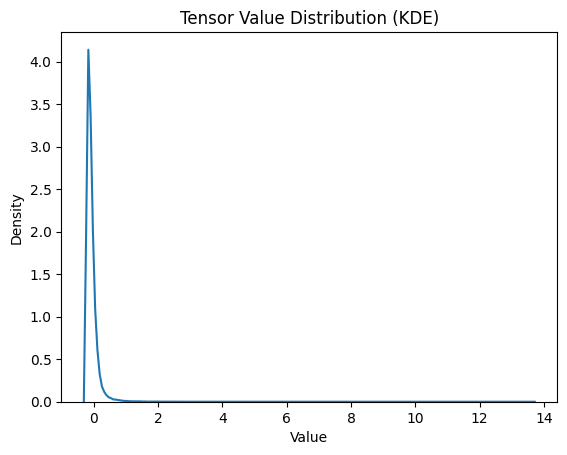

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(full_languages_raw_values[0][0][0], bw_adjust=0.5)
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Tensor Value Distribution (KDE)")
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


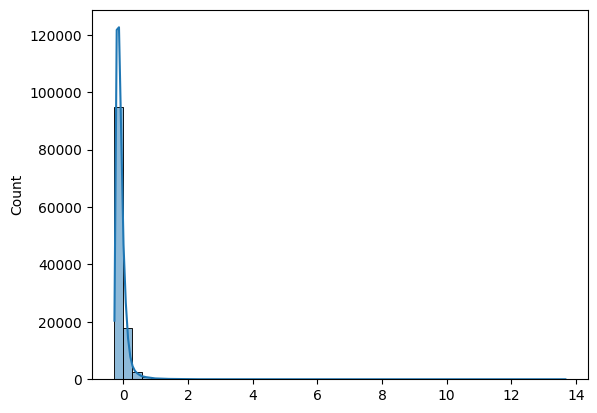

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(full_languages_raw_values[0][0][0], kde=True, bins=50)
plt.show()


In [13]:
%pip install fitter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
rel_breitwigner,0.039677,2224.501486,2253.504497,inf,0.077358,0.000000e+00
loglaplace,0.114026,1558.451874,1587.454884,inf,0.045254,3.482055e-208
moyal,0.114435,9847.657344,9866.992685,inf,0.070180,0.000000e+00
kappa3,0.116708,2314.747823,2343.750833,inf,0.094510,0.000000e+00
beta,0.233213,11308.564048,11347.234729,inf,0.062553,0.000000e+00


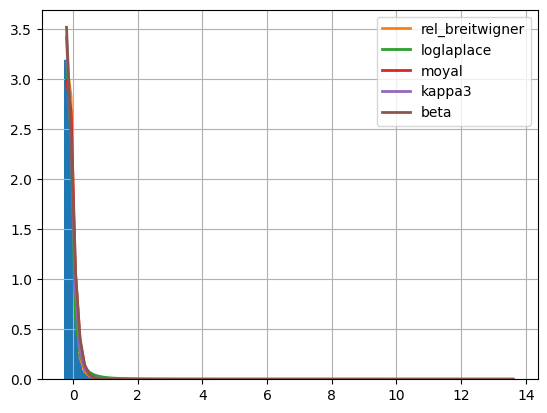

In [14]:
from fitter import Fitter

f = Fitter(full_languages_raw_values[0][0][0])
f.fit()
f.summary()


In [10]:
import numpy as np
import scipy.stats as stats

# List of distributions to test
distributions = ["norm", "expon", "gamma", "lognorm", "beta", "weibull_min"]

best_fit = None
best_pvalue = 0

for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(full_languages_raw_values[0][0][0])  # Fit distribution to data
    stat, p_value = stats.kstest(full_languages_raw_values[0][0][0], dist_name, args=params)  # KS test

    print(f"{dist_name}: p-value = {p_value:.4f}")

    if p_value > best_pvalue:
        best_pvalue = p_value
        best_fit = dist_name

print(f"\nBest fitting distribution: {best_fit}")


norm: p-value = 0.0000
expon: p-value = 0.0000
gamma: p-value = 0.0000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:952: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:6574: RuntimeWarning: invalid value encountered in greater_equal
  while dL_dLoc_rbrack >= -1e-6:


lognorm: p-value = 0.0000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


beta: p-value = 0.0000
weibull_min: p-value = 0.0000

Best fitting distribution: lognorm


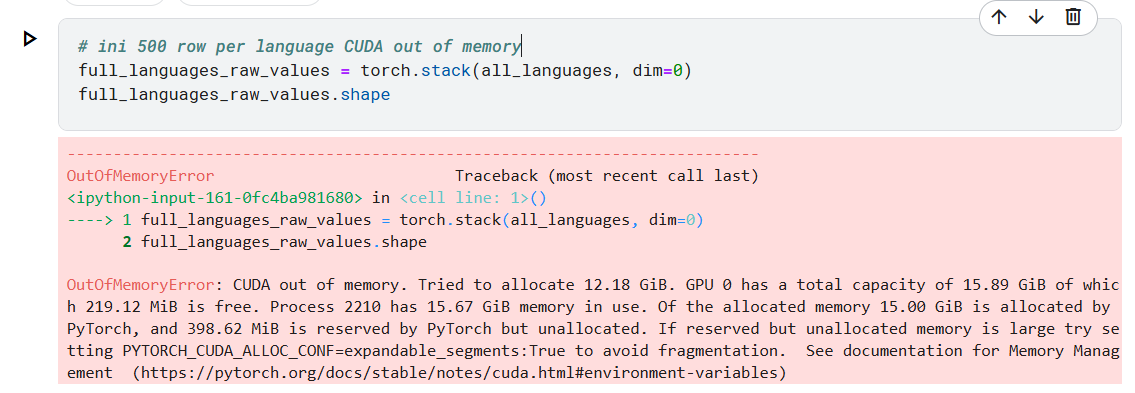

In [39]:
len(all_languages)

52

In [42]:
torch.save(full_languages_raw_values, "raw_qwen05_predict_massive200.pt")

In [14]:
full_languages_raw_values = torch.load("raw_qwen05_predict_massive200.pt")
full_languages_raw_values.shape

<ipython-input-14-8bd4e37ece35>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  full_languages_raw_values = torch.load("raw_qwen05_predict_massive200.pt")


torch.Size([52, 2, 200, 116736])

### satuin semua jadi kelas 
blm selesai


In [ ]:
class NeuronActValues:
    def __init__(self, model_name, device):
        self.raw_values_avg_tokens = {}
        self.raw_values_last_token = {}
        self.clean_hooks()
        

    def save_raw_vals_to_dict(name, dictname, savees):
    if not name in dictname:
        dictname[name] = savees
    else:
        dictname[name] = torch.cat([dictname[name], savees], dim=0)
    
    def clean_hooks():
        for i in range(len(infer_model.model.model.layers)):
            mlp = infer_model.model.model.layers[i].mlp
            mlp.act_fn._forward_hooks.clear()
    
    def get_activation_mlp(name): 
        """
            name (str): buat namain layer
            is_averaged_tokens (boolean): true if avergaed across tokens, else get the last token
        """
        def hook_fn(module, input, output):
            global raw_values_avg_tokens
            global raw_values_last_token
            # print(f"Layer: {name}, output Shape: {output.shape}")
            # print("Output", output)
            # output is always (batch size, dim_neuron_in_a_layer)
            # if is_averaged_tokens: # simpen average value across tokens
            avg_output = output.float().mean(dim=1) 
            save_raw_vals_to_dict(name, raw_values_avg_tokens, avg_output)
            # else:
            last_output = output.float()[:, -1,:] # simpen the last token
            save_raw_vals_to_dict(name, raw_values_last_token, last_output)
            
            
        return hook_fn
    
    def concat_neuron_layers(raw_values_avg_tokens, raw_values_last_token):
        full_raw_values_avg_tokens = list(raw_values_avg_tokens.values())[0]
        full_raw_values_last_token = list(raw_values_last_token.values())[0]
        
        # print(full_raw_values_avg_tokens.shape)
        # print(full_raw_values_last_token.shape)
        for i in list(raw_values_avg_tokens.values())[1:]:
            # print(i.shape)
            full_raw_values_avg_tokens = torch.cat([full_raw_values_avg_tokens, i], dim=-1)
        for i in list(raw_values_last_token.values())[1:]:
            full_raw_values_last_token = torch.cat([full_raw_values_last_token, i], dim=-1)
        # print(f"shape full_raw_values_last_token {full_raw_values_last_token.shape}")
        return full_raw_values_avg_tokens, full_raw_values_last_token
    
    
    def merge_avg_last(full_raw_values_avg_tokens, full_raw_values_last_token):
        # print(f"shape full_raw_values_last_token {full_raw_values_last_token.shape}")
        full_raw_values = torch.stack((full_raw_values_avg_tokens, full_raw_values_last_token), dim=0)
        return full_raw_values
    






### Pairing antar language

#### Kesamaan index neuron yang teraktivasi.
- Case 1: Neuron yang teraktivasi -> yang actv. valuenya di atas 0 untuk seluruh data point di dataset
- Case 2: Neuron yang teraktivasi -> anggap abs(actv_value) > 0.5 = 1 -> neuron yang probability munculnya > meannya itu yang teraktivasi

#### ===== activation value dengan prompt tanpa predict (fully in their own languages)

case 1

In [4]:
languages_52 = torch.load("massive_qwen05_neuron_raw_values.pt")
languages_52.shape

<ipython-input-4-0238aecf2e23>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  languages_52 = torch.load("massive_qwen05_neuron_raw_values.pt")


FileNotFoundError: [Errno 2] No such file or directory: 'massive_qwen05_neuron_raw_values.pt'

di sini anggap activated neuron (avg token) yang di setiap row di dataset(cuman 2 row) actv valuenya > 0

In [22]:
def get_k_lang_actv_dict(k, full_neurons, method="default"):
    """ k = num language"""
    activation_dict = {}
    
    full_neurons = full_neurons.transpose(-3,-4)[0].transpose(-1,-2)
    for i in range (full_neurons.size(0)):
        tensor_lang = full_neurons[i]
        rows_with_both_positive = (tensor_lang > 0).all(dim=-1)
        
        indices = torch.where(rows_with_both_positive)[0]
        activation_dict[i] = indices
        # indices.shape
        # print(indices.shape)
    return activation_dict

In [34]:
import numpy as np
from scipy.stats import entropy



# Step 1: Convert lists to probability distributions
def to_probability_distribution(values):
    total = sum(values)
    return [v / total for v in values]



In [76]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def make_heatmap_neuron_overlap(activation_dict, k, with_label=True, method="default", alpha=1, normalized =False):    
    # Example dictionary: keys 0-52, values are 1D tensors of activated neuron indices
    # activation_dict = get_k_lang_actv_dict(10)

    overlap_matrix = torch.tensor([])
    if method == "default":
        # Step 1: Create a binary matrix
        max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1  # Find the maximum neuron index
        binary_matrix = torch.zeros((k+1, max_neuron_index), dtype=torch.int)  # Initialize binary matrix
        
        for key, indices in activation_dict.items():
            binary_matrix[key, indices] = 1  # Set activated neurons to 1
        
        # Step 2: Compute overlaps (dot product between rows)
        overlap_matrix = torch.matmul(binary_matrix, binary_matrix.T)  # Dot product of binary_matrix with its transpose

    elif method == "jaccard":
        max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1
        binary_matrix = torch.zeros((k+1, max_neuron_index), dtype=torch.int)
    
        # Fill binary matrix with activation data
        for key, indices in activation_dict.items():
            binary_matrix[key, indices] = 1  
    
        # Compute Jaccard distance matrix
        overlap_matrix = torch.zeros((k+1, k+1))
    
        for i in range(k+1):
            for j in range(k+1):
                intersection = (binary_matrix[i] & binary_matrix[j]).sum().item()
                union = (binary_matrix[i] | binary_matrix[j]).sum().item()
                jaccard_similarity = intersection / union if union > 0 else 0
                overlap_matrix[i, j] = jaccard_similarity
        overlap_matrix = overlap_matrix ** alpha
        if normalized:
            overlap_matrix = overlap_matrix / overlap_matrix.sum(axis=1, keepdims=True)

    elif method == "kl":
        # Create a dictionary of probability distributions
        prob_dict = {k: to_probability_distribution(v) for k, v in activation_dict.items()}
        
        # Step 2: Compute pairwise KL divergence
        num_keys = len(prob_dict)
        overlap_matrix = np.zeros((num_keys, num_keys))
        
        for i in range(num_keys):
            for j in range(num_keys):
                if i == j:
                    overlap_matrix[i, j] = 0  # KL divergence of a distribution with itself is 0
                else:
                    # Compute KL divergence (ensure no zero probabilities to avoid log(0))
                    p = np.array(prob_dict[i]) + 1e-10  # Add small epsilon to avoid zeros
                    q = np.array(prob_dict[j]) + 1e-10
                    overlap_matrix[i, j] = entropy(p, q)
    
        # Step 5: Apply **scaling to highlight differences**
        overlap_matrix = overlap_matrix ** alpha  
    
    # Step 3: Visualize the heatmap
    plt.figure(figsize=(10, 8))
    if with_label:
        sns.heatmap(overlap_matrix.numpy(), annot=True, fmt="d", cmap="YlOrRd", 
                    xticklabels=range(k+1), yticklabels=range(k+1))
    else:
        sns.heatmap(overlap_matrix.numpy(), fmt="d", cmap="YlOrRd",cbar=True)
    plt.xlabel("Key")
    plt.ylabel("Key")
    plt.title(f"Overlap Heatmap of Activated Neurons: {method}")
    plt.show()
    return overlap_matrix

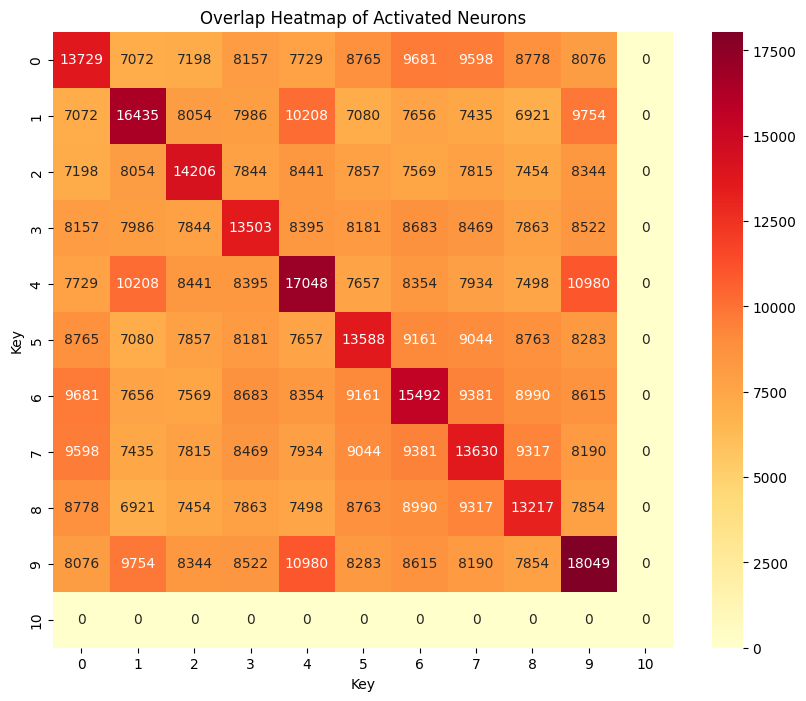

In [228]:
activation_dict = get_k_lang_actv_dict(10, languages_52)
res_10 = make_heatmap_neuron_overlap(activation_dict, 10, True)

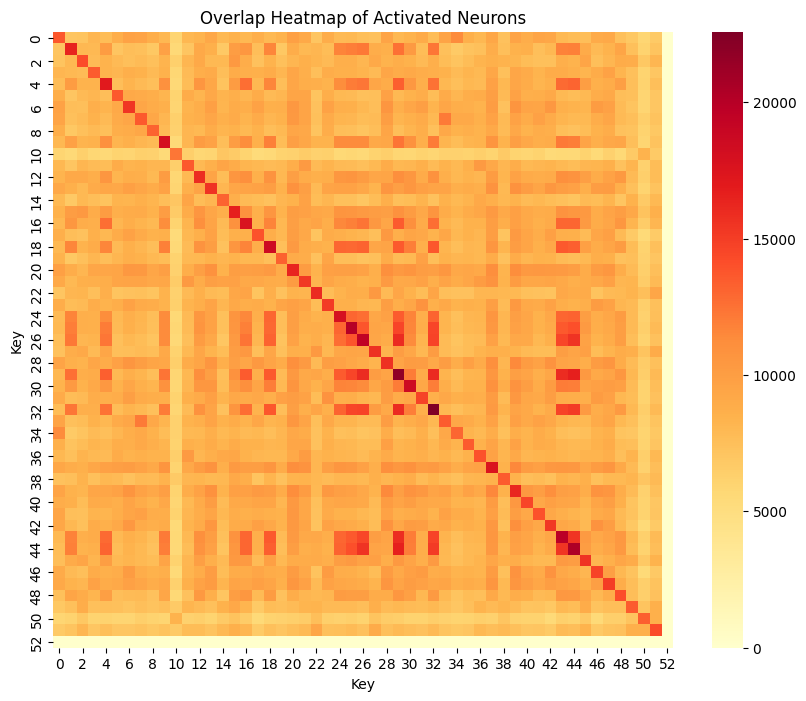

In [216]:
activation_dict = get_k_lang_actv_dict(52)
make_heatmap_neuron_overlap(activation_dict, 52, False)

In [11]:
# normalized, tiap kolom (m,n) isinya jumlah overlap neuron dibagi min(m,n)
import torch
import matplotlib.pyplot as plt
import seaborn as sns


def normed_heatmap_neuron_overlap(num_lang, activation_dict):
    # Step 1: Create a binary matrix
    max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1  # Find the maximum neuron index
    binary_matrix = torch.zeros((num_lang, max_neuron_index), dtype=torch.int)  # Initialize binary matrix
    
    for key, indices in activation_dict.items():
        binary_matrix[key, indices] = 1  # Set activated neurons to 1
    
    # Step 2: Compute overlaps (dot product between rows)
    overlap_matrix = torch.matmul(binary_matrix, binary_matrix.T)  # Dot product of binary_matrix with its transpose
    
    # Step 3: Normalize the overlap matrix
    # Compute the number of activated neurons for each key
    num_activated_neurons = binary_matrix.sum(dim=1, keepdim=True)
    
    # Normalize by the minimum number of activated neurons between each pair of keys
    normalized_overlap_matrix = overlap_matrix / torch.minimum(
        num_activated_neurons, num_activated_neurons.T
    )
    
    # Ensure the diagonal is exactly 1 (self-overlap is always 1)
    normalized_overlap_matrix.fill_diagonal_(1)
    
    # Step 4: Visualize the normalized heatmap (no labels or annotations)
    plt.figure(figsize=(10, 8))
    sns.heatmap(normalized_overlap_matrix.numpy(), cmap="YlOrRd", cbar=True, vmin=0, vmax=1)
    plt.xlabel("Key")
    plt.ylabel("Key")
    plt.title("Normalized Overlap Heatmap of Activated Neurons")
    plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


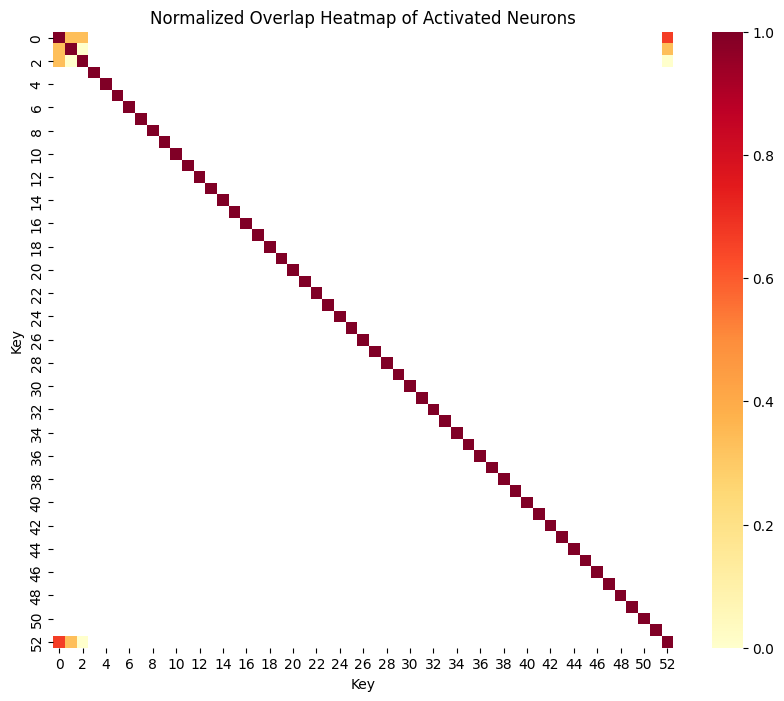

In [221]:
normed_heatmap_neuron_overlap(num_lang, activation_dict)

#### =====activation value dengan prompt predict (prompts in english)

#### Visualisasi distribusi neurons 

lihat distribusi nilai neurons 

very similar neurons activated for prompts in english for every language

-> may need to sort out the specific only to the pair of language

In [7]:
torch.topk(-full_languages_raw_values[0][0][0], 10)

torch.return_types.topk(
values=tensor([0.2720, 0.2708, 0.2705, 0.2700, 0.2700, 0.2698, 0.2695, 0.2693, 0.2693,
        0.2690]),
indices=tensor([46213, 73346, 44423, 40603, 43678, 48568, 37275, 40325, 63806, 73984]))

In [57]:
full_languages_raw_values[10][0][0].topk(10)

torch.return_types.topk(
values=tensor([13.5391, 13.3828, 13.1484, 12.8047, 12.5625, 12.4766, 12.4531, 12.3047,
        12.0547, 11.6797]),
indices=tensor([112993, 115807, 113268, 115255, 114411, 114377, 114660, 116016, 114100,
        115866]))

In [62]:
full_languages_raw_values[0][0][0].topk(10)

torch.return_types.topk(
values=tensor([13.6719, 13.3984, 13.2266, 12.7656, 12.6641, 12.5156, 12.5156, 12.4531,
        12.0938, 11.7734]),
indices=tensor([112993, 115807, 113268, 115255, 114411, 114377, 114660, 116016, 114100,
        113213]))

In [63]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def hist_neuron_values(num_neurons, num_layer, data, label=""):
    
    num_points = num_neurons  # 116736
    step_size = num_neurons / num_layer
    # step_size = 24
    x_indices = np.arange(0, num_points, step_size)  
    x_labels = [str(i) for i in x_indices]  
    
    # Plot the data
    plt.figure(figsize=(7, 2))
    plt.plot(data.numpy(), label="Tensor Values", linewidth=0.8)  
    plt.xticks(x_indices, x_labels, rotation=45) 
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title(f"Tensor Value Distribution {label}")
    plt.legend()
    plt.show()


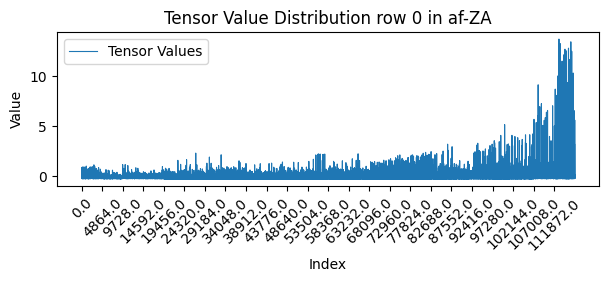

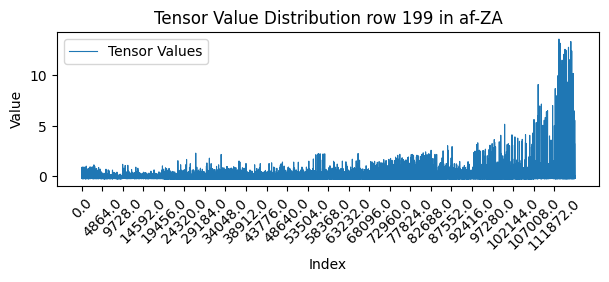

In [64]:
hist_neuron_values(116736, 24, full_languages_raw_values[0][0][0], "row 0 in af-ZA")

hist_neuron_values(116736, 24, full_languages_raw_values[0][0][199], "row 199 in af-ZA")


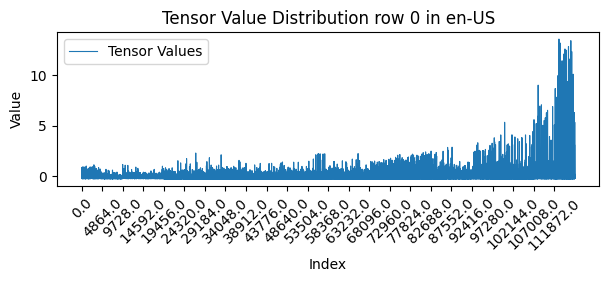

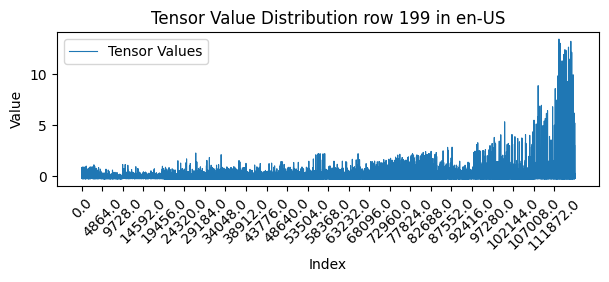

In [65]:
hist_neuron_values(116736, 24, full_languages_raw_values[10][0][0], "row 0 in en-US")

hist_neuron_values(116736, 24, full_languages_raw_values[10][0][25], "row 199 in en-US")


case 1

In [77]:
activation_dict = get_k_lang_actv_dict(52, full_languages_raw_values)

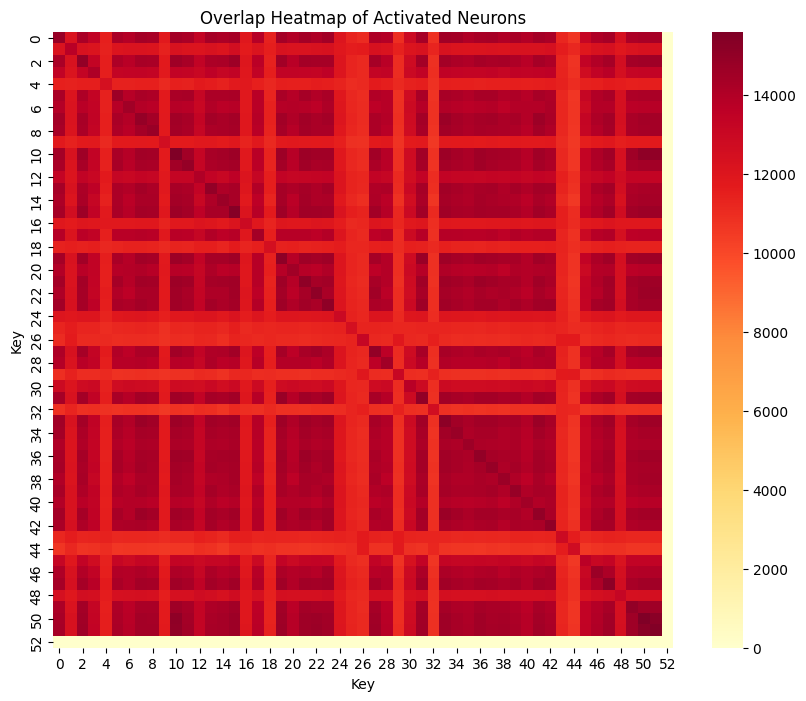

tensor([[14848, 12247, 14233,  ..., 14316, 14354,     0],
        [12247, 13731, 12308,  ..., 12322, 12355,     0],
        [14233, 12308, 14961,  ..., 14565, 14580,     0],
        ...,
        [14316, 12322, 14565,  ..., 15558, 15259,     0],
        [14354, 12355, 14580,  ..., 15259, 15546,     0],
        [    0,     0,     0,  ...,     0,     0,     0]], dtype=torch.int32)

In [106]:
make_heatmap_neuron_overlap(activation_dict, 52, False)

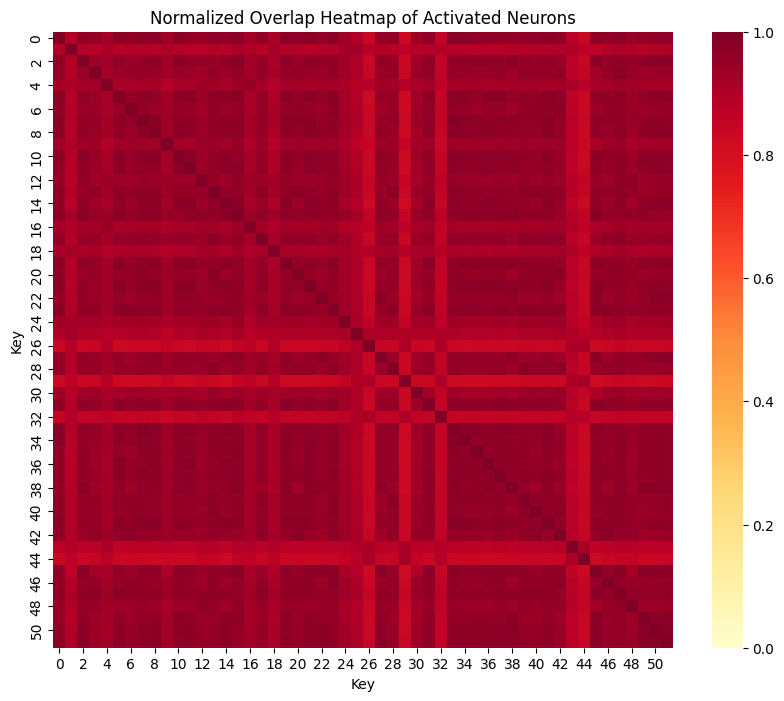

In [108]:
normed_heatmap_neuron_overlap(52, activation_dict)

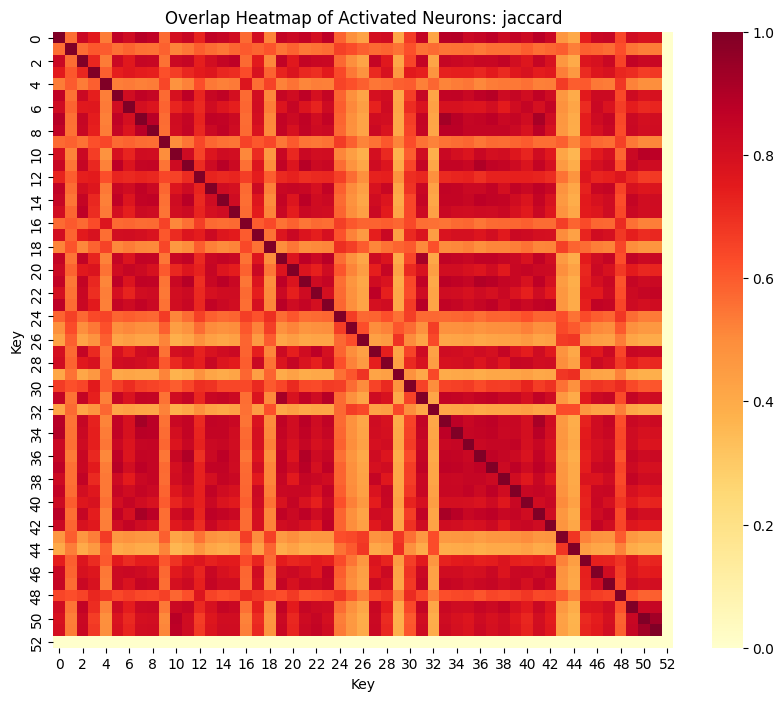

tensor([[1.0000, 0.5623, 0.8350,  ..., 0.7916, 0.8008, 0.0000],
        [0.5623, 1.0000, 0.5643,  ..., 0.5274, 0.5331, 0.0000],
        [0.8350, 0.5643, 1.0000,  ..., 0.8335, 0.8380, 0.0000],
        ...,
        [0.7916, 0.5274, 0.8335,  ..., 1.0000, 0.9274, 0.0000],
        [0.8008, 0.5331, 0.8380,  ..., 0.9274, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [21]:
make_heatmap_neuron_overlap(activation_dict, 52, False, "jaccard", 2)

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


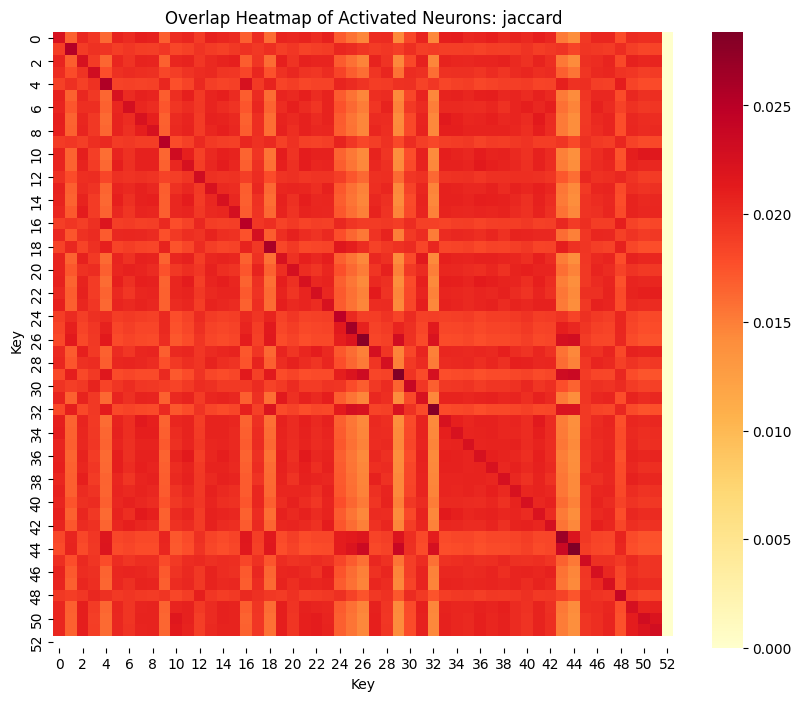

tensor([[0.0223, 0.0167, 0.0204,  ..., 0.0199, 0.0200, 0.0000],
        [0.0190, 0.0253, 0.0190,  ..., 0.0184, 0.0185, 0.0000],
        [0.0205, 0.0169, 0.0225,  ..., 0.0205, 0.0206, 0.0000],
        ...,
        [0.0205, 0.0167, 0.0210,  ..., 0.0230, 0.0222, 0.0000],
        [0.0205, 0.0167, 0.0210,  ..., 0.0221, 0.0229, 0.0000],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan]])

In [78]:
make_heatmap_neuron_overlap(activation_dict, 52, False, "jaccard", 1, True)

case 2

In [15]:
check_cpu_memory()

Total Memory: 31.35 GB
Available Memory: 20.51 GB
Used Memory: 10.40 GB
Memory Usage: 34.6%


In [ ]:
import torch
import torch.nn.functional as F

# Example: Random probability distributions (52 x 116736)
# torch.manual_seed(0)
activation_tensor = full_languages_raw_values.transpose(0,1)[0][:, 0, :].clamp(min=0)
eps = 1e-10
# Normalize each row to sum to 1 (convert to probability distributions)
activation_tensor = activation_tensor / (activation_tensor.sum(dim=1, keepdim=True) + eps)
# activation_tensor.shape
# Compute KL divergence matrix (52 x 52)
kl_matrix = torch.zeros(52, 52)

for i in range(52):
    for j in range(52):
        kl_matrix[i, j] = F.kl_div(
            (activation_tensor[j]+eps).log(),  # Q (log-probabilities)
            activation_tensor[i],        # P (reference distribution)
            reduction="sum"              # Sum over all neurons
        )

# print(kl_matrix.shape)  # Should be (52, 52)


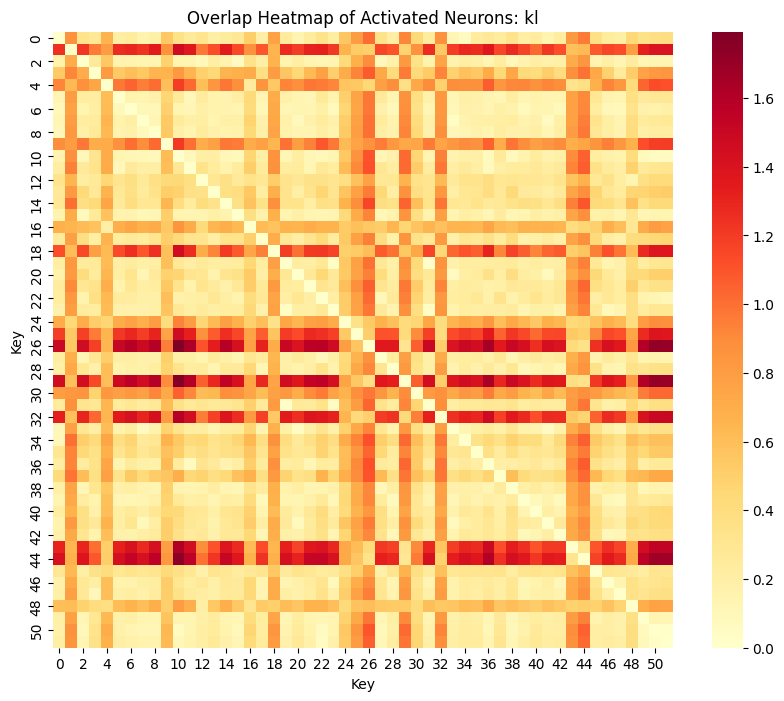

In [71]:
plt.figure(figsize=(10, 8))
if with_label:
    sns.heatmap(kl_matrix.numpy(), annot=True, fmt="d", cmap="YlOrRd", 
                xticklabels=range(k+1), yticklabels=range(k+1))
else:
    sns.heatmap(kl_matrix, fmt="d", cmap="YlOrRd",cbar=True)
plt.xlabel("Key")
plt.ylabel("Key")
plt.title(f"Overlap Heatmap of Activated Neurons: {method}")
plt.show()

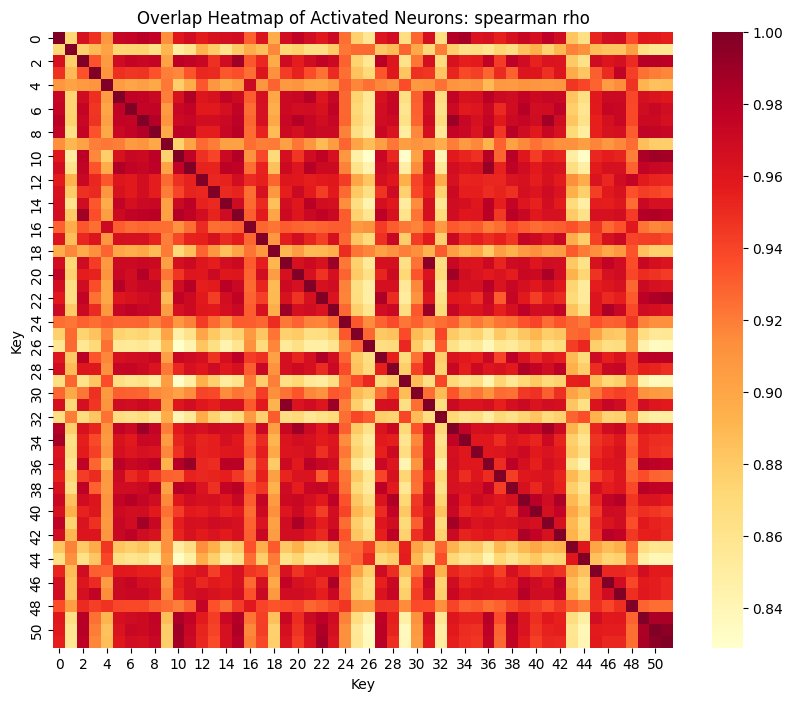

In [75]:
import torch
import scipy.stats

activation_tensor = full_languages_raw_values.transpose(0,1)[0][:, 0, :]
rho_matrix = torch.zeros(52, 52)  # Initialize Spearman rho matrix

# Compute Spearman's rho for each pair of rows
for i in range(52):
    for j in range(52):
        rho, _ = scipy.stats.spearmanr(activation_tensor[i].cpu().numpy(), activation_tensor[j].cpu().numpy())
        rho_matrix[i, j] = rho  # Store result

# print(rho_matrix)
plt.figure(figsize=(10, 8))
if with_label:
    sns.heatmap(rho_matrix, annot=True, fmt="d", cmap="YlOrRd", 
                xticklabels=range(k+1), yticklabels=range(k+1))
else:
    sns.heatmap(rho_matrix, fmt="d", cmap="YlOrRd",cbar=True)
plt.xlabel("Key")
plt.ylabel("Key")
plt.title(f"Overlap Heatmap of Activated Neurons: spearman rho")
plt.show()

### LAPE

In [5]:
full_languages_raw_values = (full_languages_raw_values.transpose(0,1)[0] > 0).half()

In [24]:
probs = full_languages_raw_values.mean(dim=-2)
probs.shape

NameError: name 'full_languages_raw_values' is not defined

In [7]:
del full_languages_raw_values

In [56]:
((probs != 0) & (probs != 1)).any()

tensor(True)

In [14]:
def LAPE(activation_probs, top_rate = 0.01,filter_rate=0.95,activation_bar_ratio=0.95):
    """    
    activation_probs = # layer x inter x lang_num
    """    
    num_layers = activation_probs.size(0)
    normed_activation_probs = activation_probs / activation_probs.sum(dim=-1, keepdim=True)
    normed_activation_probs[torch.isnan(normed_activation_probs)] = 0
    log_probs = torch.where(normed_activation_probs > 0, normed_activation_probs.log(), 0)
    entropy = -torch.sum(normed_activation_probs * log_probs, dim=-1)
    largest = False
    
    if torch.isnan(entropy).sum():
        print(torch.isnan(entropy).sum())
        raise ValueError
    
    flattened_probs = activation_probs.flatten()
    top_prob_value = flattened_probs.kthvalue(round(len(flattened_probs) * filter_rate)).values.item()
    print(top_prob_value)
    # dismiss the neruon if no language has an activation value over top 90%
    top_position = (activation_probs > top_prob_value).sum(dim=-1)
    entropy[top_position == 0] = -torch.inf if largest else torch.inf

    flattened_entropy = entropy.flatten()
    top_entropy_value = round(len(flattened_entropy) * top_rate)
    _, index = flattened_entropy.topk(top_entropy_value, largest=largest)
    row_index = index // entropy.size(1)
    col_index = index % entropy.size(1)
    selected_probs = activation_probs[row_index, col_index] # n x lang
    # for r, c in zip(row_index, col_index):
    #     print(r, c, activation_probs[r][c])

    # print(selected_probs.size(0), torch.bincount(selected_probs.argmax(dim=-1)))
    selected_probs = selected_probs.transpose(0, 1)
    activation_bar = flattened_probs.kthvalue(round(len(flattened_probs) * activation_bar_ratio)).values.item()
    # print((selected_probs > activation_bar).sum(dim=1).tolist())
    lang, indice = torch.where(selected_probs > activation_bar)

    merged_index = torch.stack((row_index, col_index), dim=-1)
    final_indice = []
    for _, index in enumerate(indice.split(torch.bincount(lang).tolist())):
        lang_index = [tuple(row.tolist()) for row in merged_index[index]]
        lang_index.sort()
        layer_index = [[] for _ in range(num_layers)]
        for l, h in lang_index:
            layer_index[l].append(h)
        for l, h in enumerate(layer_index):
            layer_index[l] = torch.tensor(h).long()
        final_indice.append(layer_index)
    return final_indice

In [26]:
probs = probs.reshape(52,24,4864)
transposed_probs = probs.transpose(0,1).transpose(-1,-2)
transposed_probs.shape

torch.Size([24, 4864, 52])

In [ ]:
lape = LAPE(transposed_probs, top_rate = 0.01,filter_rate=0.80,activation_bar_ratio=0.80)


In [28]:
len(lape)

52

In [23]:
def convert_to_global_indices(final_indice, intermediate_size):
    final_flattened = []
    
    for lang_idx, layers in enumerate(final_indice):  # Iterate over languages
        global_indices = []
        for layer_idx, hidden_units in enumerate(layers):  # Iterate over layers
            if hidden_units.numel() > 0:  # If there are selected neurons
                global_indices.extend((layer_idx * intermediate_size + hidden_units).tolist())
        
        final_flattened.append((global_indices))  
    
    return final_flattened

# Example usage:
intermediate_size = 4864 
flattened_indices = convert_to_global_indices(lape, intermediate_size)


In [24]:
activation_dict = dict()
for i in range (52):
    activation_dict[i] = flattened_indices[i]

Jaccard similarity LAPE neurons. Sedikit yang overlap karena LAPE language-specific dan kemungkinannya kecil untuk sharing between neurons

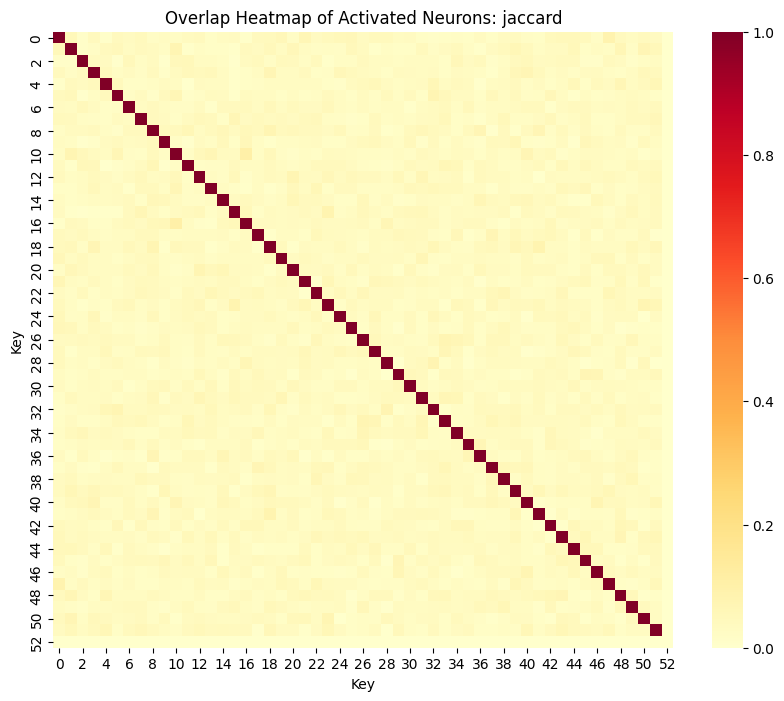

tensor([[1.0000, 0.0511, 0.0120,  ..., 0.0393, 0.0333, 0.0000],
        [0.0511, 1.0000, 0.0120,  ..., 0.0698, 0.0511, 0.0000],
        [0.0120, 0.0120, 1.0000,  ..., 0.0244, 0.0305, 0.0000],
        ...,
        [0.0393, 0.0698, 0.0244,  ..., 1.0000, 0.0278, 0.0000],
        [0.0333, 0.0511, 0.0305,  ..., 0.0278, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [27]:
make_heatmap_neuron_overlap(activation_dict, 52, False, "jaccard", 1)

In [52]:
full_languages_raw_values.transpose(0,1)[0][:, 0, :] .shape

torch.Size([52, 116736])

#### intervention LAPE


In [67]:
def test_inference(prompt, max_new_tokens):
    generated_text = infer_model.inference(prompt, max_new_tokens)
    # print(f"data: {prompt}")
            
    print(f"gen_text {generated_text}")

In [68]:
clean_hooks()
for i in handlers:
    i.remove()
        

In [69]:
prompt_indo = "batalkan alarm saya pukul tujuh pagi"
test_inference(prompt_indo, 10)

gen_text Tentu saja, saya akan membantu Anda


In [129]:
lape_indo = lape[19]

In [140]:
def set_activation_mlp(name, lape_lang): 
    """
        name (str): buat namain layer
        is_averaged_tokens (boolean): true if avergaed across tokens, else get the last token
    """
    def hook_fn(module, input, output):
        layer = int(name)
        output[0, :, lape_lang[layer]] = -1
        # print(f"nama {name}")
        # print(f"output shape {output.shape}")
    return hook_fn
            
        


In [97]:
lape_indo[0].shape

torch.Size([3])

In [96]:
torch.tensor([2,3]).shape

torch.Size([2])

In [94]:
tensor = torch.randn(1,2,4)
print(tensor)
print(tensor[:,:,torch.tensor([2,3])])
# lape_indo[0]

tensor([[[ 0.2815,  0.0562,  0.5227, -0.2384],
         [-0.0499,  0.5263, -0.0085,  0.7291]]])
tensor([[[ 0.5227, -0.2384],
         [-0.0085,  0.7291]]])


In [141]:
def intervensi(prompt, lape_lang, max_new_tokens=1):
    clean_hooks()
    
            
    handlers = []
    for i in range (24):
        mlp = infer_model.model.model.layers[i].mlp
        handlers.append(mlp.act_fn.register_forward_hook(set_activation_mlp(f"{i}", lape_lang)))
    test_inference(prompt, max_new_tokens)
    for i in handlers:
        i.remove()

# for i in handlers:
#     i.remove()

#### intervensi untuk prompt bahasa indonesia

intervensi neuron indo

In [142]:
prompt_indo = "batalkan alarm saya pukul tujuh pagi"

intervensi(prompt_indo, lape_indo, 10)

gen_text Tentu saja, saya akan membantu Anda


intervensi neuron malaysia

In [144]:
lape_malay = lape[31]

intervensi(prompt_indo, lape_malay, 10)

gen_text Sebagai asisten AI, saya tidak dapat mel


intervensi neuron inggris

In [145]:
lape_en = lape[10]

intervensi(prompt_indo, lape_en, 10)

gen_text Sebagai AI yang dirancang untuk membantu


intervensi neuron jawa

In [146]:
lape_jv = lape[23]

intervensi(prompt_indo, lape_jv, 10)

gen_text Tentu saja, saya akan membantu Anda


=================================

In [51]:
import numpy as np
from scipy.stats import entropy

with_label = False
k=52
method = "kl"
# Define the number of bins for the histograms
# num_bins = 10

 
# Convert lists to histograms
hist_dict = {}

for i in range(52):
    hist_dict[i] = full_languages_raw_values.transpose(0,1)[0][:, 0, :][i] 
# for k, v in activation_dict.items():
#     hist, bin_edges = np.histogram(v, bins=num_bins, density=True)
#     hist_dict[k] = hist

# Compute pairwise KL divergence



# Step 1: Convert lists to probability distributions
def to_probability_distribution(values):
    total = sum(values)
    return [v / total for v in values]

# Create a dictionary of probability distributions
prob_dict = {k: to_probability_distribution(v) for k, v in hist_dict.items()}

# Step 2: Compute pairwise KL divergence
num_keys = len(prob_dict)
kl_matrix = np.zeros((num_keys, num_keys))

for i in range(num_keys):
    for j in range(num_keys):
        if i == j:
            kl_matrix[i, j] = 0  # KL divergence of a distribution with itself is 0
        else:
            # Compute KL divergence (ensure no zero probabilities to avoid log(0))
            p = np.array(prob_dict[i]) + 1e-10  # Add small epsilon to avoid zeros
            q = np.array(prob_dict[j]) + 1e-10
            kl_matrix[i, j] = entropy(p, q)


print("KL Divergence Matrix:")
 # Step 3: Visualize the heatmap
plt.figure(figsize=(10, 8))
if with_label:
    sns.heatmap(kl_matrix.numpy(), annot=True, fmt="d", cmap="YlOrRd", 
                xticklabels=range(k+1), yticklabels=range(k+1))
else:
    sns.heatmap(kl_matrix, fmt="d", cmap="YlOrRd",cbar=True)
plt.xlabel("Key")
plt.ylabel("Key")
plt.title(f"Overlap Heatmap of Activated Neurons: {method}")
plt.show()

KeyboardInterrupt: 

In [69]:
import torch
import torch.nn.functional as F

# Example: Random probability distributions (52 x 116736)
# torch.manual_seed(0)
activation_tensor = full_languages_raw_values.transpose(0,1)[0][:, 0, :].clamp(min=0)
eps = 1e-10
# Normalize each row to sum to 1 (convert to probability distributions)
activation_tensor = activation_tensor / (activation_tensor.sum(dim=1, keepdim=True) + eps)
# activation_tensor.shape
# Compute KL divergence matrix (52 x 52)
kl_matrix = torch.zeros(52, 52)

for i in range(52):
    for j in range(52):
        kl_matrix[i, j] = F.kl_div(
            (activation_tensor[j]+eps).log(),  # Q (log-probabilities)
            activation_tensor[i],        # P (reference distribution)
            reduction="sum"              # Sum over all neurons
        )

# print(kl_matrix.shape)  # Should be (52, 52)


In [62]:
activation_tensor.shape

torch.Size([52, 116736])

In [70]:
kl_matrix


tensor([[-2.2916e-06,  8.5916e-01,  3.2413e-01,  ...,  3.5052e-01,
          3.7970e-01,  3.9047e-01],
        [ 1.2531e+00, -2.3260e-06,  1.2246e+00,  ...,  1.3213e+00,
          1.4030e+00,  1.4009e+00],
        [ 1.6758e-01,  7.0802e-01, -2.2512e-06,  ...,  1.1276e-01,
          1.2936e-01,  1.3663e-01],
        ...,
        [ 1.9268e-01,  7.8088e-01,  1.1734e-01,  ..., -2.2685e-06,
          1.3283e-01,  1.1968e-01],
        [ 1.8185e-01,  8.6268e-01,  9.4742e-02,  ...,  8.3139e-02,
         -2.3205e-06,  2.2925e-02],
        [ 2.0472e-01,  8.4755e-01,  1.2307e-01,  ...,  9.0643e-02,
          3.7003e-02, -2.2894e-06]])

In [ ]:
def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + 0.5 * (entropy(q, m)))

num_keys = 52                  
# Compute pairwise Jensen-Shannon divergence
js_matrix = np.zeros((num_keys, num_keys))

for i in range(num_keys):
    for j in range(num_keys):
        if i == j:
            js_matrix[i, j] = 0
        else:
            p = np.array(prob_dict[i]) + 1e-10
            q = np.array(prob_dict[j]) + 1e-10
            js_matrix[i, j] = jensen_shannon_divergence(p, q)

print("Jensen-Shannon Divergence Matrix:")
plt.figure(figsize=(10, 8))
if with_label:
    sns.heatmap(js_matrix, annot=True, fmt="d", cmap="YlOrRd", 
                xticklabels=range(k+1), yticklabels=range(k+1))
else:
    sns.heatmap(js_matrix, fmt="d", cmap="YlOrRd",cbar=True)
plt.xlabel("Key")
plt.ylabel("Key")
plt.title(f"Overlap Heatmap of Activated Neurons: js")
plt.show()

In [32]:
activation_dict[0]

[1279,
 3188,
 3807,
 10575,
 11106,
 11428,
 14549,
 16292,
 16531,
 17222,
 18387,
 18783,
 19506,
 21149,
 21735,
 22188,
 22296,
 22559,
 22591,
 22978,
 23022,
 23740,
 26025,
 26579,
 27224,
 27910,
 28671,
 29905,
 32898,
 32921,
 33047,
 33148,
 38150,
 38422,
 39749,
 41056,
 41307,
 45082,
 45928,
 47022,
 48114,
 48263,
 49177,
 49446,
 51364,
 53749,
 54136,
 58051,
 58200,
 58239,
 61581,
 62186,
 62522,
 64106,
 66814,
 69383,
 70750,
 70798,
 71244,
 71793,
 73122,
 74406,
 74640,
 74899,
 75352,
 75881,
 76691,
 80307,
 81400,
 82235,
 84217,
 86067,
 89627,
 91076,
 93181,
 93399,
 93556,
 94189,
 95022,
 95095,
 95230,
 95632,
 95936,
 96912,
 98215,
 104665,
 107803,
 108299,
 110039,
 113019,
 115030,
 115267,
 115680]

In [ ]:
def LAPE(prob):
    normed_prob = prob / prob.sum(dim=-1, keepdim=True)
    normed_prob[torch.isnan(normed_prob)] = 0
    log_probs = torch.where(normed_prob > 0, normed_prob.log(), 0)
    entropy = -torch.sum(normed_prob * log_probs, dim=-1)


In [29]:
tensor = torch.tensor([[0.6, 0.6, 0, 1], [0, 0,0,0.5]])
tensor.reshape(2,2,2)

tensor([[[0.6000, 0.6000],
         [0.0000, 1.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.5000]]])

In [20]:
tensor = torch.tensor([[0.6, 0.6, 0, 1], [0, 0,0,0.5]])
print(tensor.shape)
tensor = tensor.transpose(-1,-2).unsqueeze(0)
print(tensor)
normed = tensor / tensor.sum(dim=-1, keepdim=True)
normed[torch.isnan(normed)] = 0
print(normed)
log_probs = torch.where(normed > 0, normed.log(), 0)
entropy = -torch.sum(normed * log_probs, dim=-1)
entropy

torch.Size([2, 4])
tensor([[[0.6000, 0.0000],
         [0.6000, 0.0000],
         [0.0000, 0.0000],
         [1.0000, 0.5000]]])
tensor([[[1.0000, 0.0000],
         [1.0000, 0.0000],
         [0.0000, 0.0000],
         [0.6667, 0.3333]]])


tensor([[-0.0000, -0.0000, -0.0000, 0.6365]])

In [199]:
tensor.shape

torch.Size([1, 4, 2])

In [21]:
# tensor = torch.randn(2,2,3)
# print(tensor)
largest = False
flattened_probs = tensor.flatten()
filter_rate = 0.10
top_prob_value = flattened_probs.kthvalue(round(len(flattened_probs) * filter_rate)).values.item()
print(top_prob_value)
top_position = (tensor > top_prob_value).sum(dim=-1)
print(top_position)
entropy[top_position == 0] = -torch.inf if largest else torch.inf
print(entropy)



0.0
tensor([[1, 1, 0, 2]])
tensor([[-0.0000, -0.0000,    inf, 0.6365]])


In [201]:
print(tensor)
tensor > 0.5

tensor([[[0.6000, 0.0000],
         [0.6000, 0.0000],
         [0.0000, 0.0000],
         [1.0000, 0.5000]]])


tensor([[[ True, False],
         [ True, False],
         [False, False],
         [ True, False]]])

In [202]:
entropy[top_position == 0]

tensor([inf])

In [204]:
tensor.shape

torch.Size([1, 4, 2])

In [205]:
tensor[0,0]

tensor([0.6000, 0.0000])

In [22]:
top_rate = 0.7
flattened_entropy = entropy.flatten()
top_entropy_value = round(len(flattened_entropy) * top_rate)
_, index = flattened_entropy.topk(top_entropy_value, largest=largest)
print(index)
row_index = index // entropy.size(1)
print(row_index)
col_index = index % entropy.size(1)
print(col_index)
selected_probs = tensor[row_index, col_index]  # Shape: (num_selected_neurons, num_languages)
selected_probs

tensor([1, 0, 3])
tensor([0, 0, 0])
tensor([1, 0, 3])


tensor([[0.6000, 0.0000],
        [0.6000, 0.0000],
        [1.0000, 0.5000]])

In [178]:
torch.where((selected_probs > 0.5).permute(-1,-2))

(tensor([0, 0]), tensor([0, 1]))

In [176]:
torch.where(torch.tensor([[True, True]]))

(tensor([0, 0]), tensor([0, 1]))

In [173]:
torch.where(torch.tensor([[ True, True],
        [ True, False],
        [False, False]]))

(tensor([0, 0, 1]), tensor([0, 1, 0]))

In [24]:
activation_bar_ratio = 0.5

print(selected_probs.size(0), torch.bincount(selected_probs.argmax(dim=-1)))
selected_probs = selected_probs.transpose(0, 1)
activation_bar = flattened_probs.kthvalue(round(len(flattened_probs) * activation_bar_ratio)).values.item()
print((selected_probs > activation_bar).sum(dim=1).tolist())
lang, indice = torch.where(selected_probs > activation_bar)
print(lang)
print(indice)

3 tensor([3])
[3, 1]
tensor([0, 0, 0, 1])
tensor([0, 1, 2, 2])


In [165]:
row_index

tensor([0, 0, 0])

In [25]:
merged_index = torch.stack((row_index, col_index), dim=-1)
final_indice = []
for _, index in enumerate(indice.split(torch.bincount(lang).tolist())):
    lang_index = [tuple(row.tolist()) for row in merged_index[index]]
    lang_index.sort()
    layer_index = [[] for _ in range(1)]
    for l, h in lang_index:
        layer_index[l].append(h)
    for l, h in enumerate(layer_index):
        layer_index[l] = torch.tensor(h).long()
    final_indice.append(layer_index)
final_indice


[[tensor([0, 1, 3])], [tensor([3])]]

In [140]:
tensor([[[0.6000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [1.0000, 0.5000]]])
tensor([[[1.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.6667, 0.3333]]])

TypeError: 'Tensor' object is not callable

In [138]:
selected_probs.shape

torch.Size([1, 4, 2])

In [125]:
rows_with_both_positive = (tensor > 0).all(dim=-1)
        
indices = torch.where(rows_with_both_positive)[0]
indices

tensor([], dtype=torch.int64)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data (Replace this with your actual data)
data = full_languages_raw_values[0][0][0]

# Define number of bins
num_bins = 24
bin_size = 116736 // num_bins  # 896

# Compute histogram
hist, bin_edges = np.histogram(data, bins=num_bins)

print(len(bin_edges))
# # Use only the first 24 bin edges (because np.histogram gives 25 edges)
x_labels = [f"{int(edge)}" for edge in bin_edges]  # FIXED LINE

# Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(range(num_bins), hist, width=0.8, alpha=0.7, color='b')

# # Set x-ticks
plt.xticks(range(25), x_labels, rotation=45)
# plt.xlabel("Data Range (every 896 points)")
# plt.ylabel("Frequency")
# plt.title("Distribution of 116,736 Data Points (Binned into 24)")

# # Show the plot
plt.show()



25


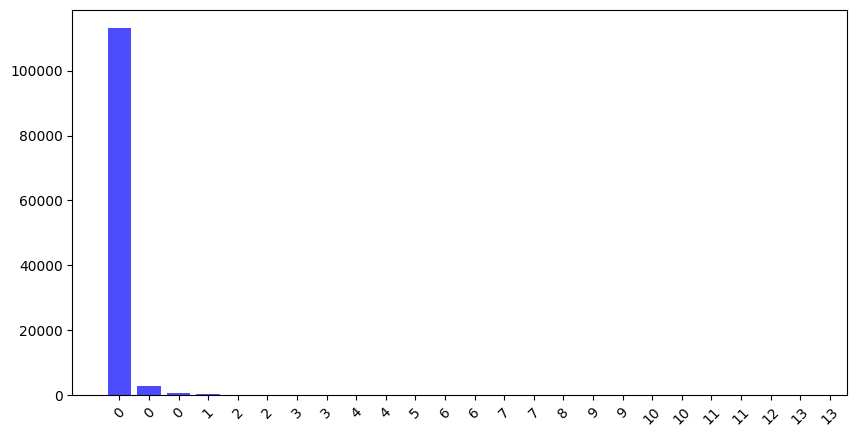

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data (Replace this with your actual data)
data = full_languages_raw_values[0][0][0]

# Define number of bins
num_bins = 24
bin_size = 116736 // num_bins  # 896

# Compute histogram
hist, bin_edges = np.histogram(data, bins=num_bins)

print(len(bin_edges))
# # Use only the first 24 bin edges (because np.histogram gives 25 edges)
x_labels = [f"{int(edge)}" for edge in bin_edges]  # FIXED LINE

# Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(range(num_bins), hist, width=0.8, alpha=0.7, color='b')

# # Set x-ticks
plt.xticks(range(25), x_labels, rotation=45)
# plt.xlabel("Data Range (every 896 points)")
# plt.ylabel("Frequency")
# plt.title("Distribution of 116,736 Data Points (Binned into 24)")

# # Show the plot
plt.show()



In [ ]:
def get_k_lang_actv_dict(k):
    activation_dict = {}
    
    for i in range (k):
        tensor_lang = per_neuron[i][0]
        rows_with_both_positive = (tensor_lang > 0).all(dim=1)
        
        indices = torch.where(rows_with_both_positive)[0]
        activation_dict[i] = indices
        # indices.shape
        # print(indices.shape)
    return activation_dict

In [ ]:
def case2():
    activation_dict = {}
    

In [126]:
del activation_dict

In [33]:
check_cpu_memory()

Total Memory: 31.35 GB
Available Memory: 29.44 GB
Used Memory: 1.47 GB
Memory Usage: 6.1%


In [31]:
full_languages_raw_values = (full_languages_raw_values > 0).half()
# full_languages_raw_values
full_languages_raw_values = full_languages_raw_values.mean(dim=-2)

In [38]:
full_languages_raw_values[0][0].shape

torch.Size([116736])

In [37]:
import torch

# Example tensor
tensor = torch.randn(1, 2, 3, 4)
print(tensor)
# Apply thresholding: |x| > 0.5 -> 1, else 0
tensor = (tensor > 0).half()

print(tensor)
tensor.mean(dim=-2).float()

tensor([[[[-1.1368, -0.5541, -0.3644,  0.4368],
          [ 0.6026, -1.1873,  0.7432,  0.6726],
          [ 1.6845,  0.5495, -1.4580, -0.2639]],

         [[-0.1335, -1.7164,  1.5173, -1.1448],
          [-0.2970, -0.0535, -0.4529, -1.2415],
          [-2.0144,  0.5850, -0.5984,  0.9487]]]])
tensor([[[[0., 0., 0., 1.],
          [1., 0., 1., 1.],
          [1., 1., 0., 0.]],

         [[0., 0., 1., 0.],
          [0., 0., 0., 0.],
          [0., 1., 0., 1.]]]], dtype=torch.float16)


tensor([[[0.6665, 0.3333, 0.3333, 0.6665],
         [0.0000, 0.3333, 0.3333, 0.3333]]])

In [15]:
tensor = torch.randn(3,6)
print(tensor)
binary_tensor = torch.where(tensor > 0, torch.tensor(1, dtype=tensor.dtype, device=tensor.device), torch.tensor(0, dtype=tensor.dtype, device=tensor.device))
print(binary_tensor)

tensor([[ 1.0669, -0.4502,  1.0311, -0.7048,  1.0131, -0.3308],
        [ 0.5177,  0.3878, -0.5797, -0.1691, -0.5733,  0.5069],
        [-0.4752, -0.4920,  0.2704, -0.5628,  0.6793,  0.4405]])
tensor([[1., 0., 1., 0., 1., 0.],
        [1., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 1.]])


#### LAPE

### === end Pairing antar language